In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import os
print(os.getcwd())

/Users/dianamartinez/Documents/Gait-Stability/NoteBooks


In [1]:
import sys
import os
os.chdir('..')
sys.path.insert(0, os.getcwd())
import numpy as np

from AE_pipeline_pytorch import (
    LSTMAutoencoder,
    BiLSTMAutoencoder,
    GaitAutoencoder,
    LSTMConvAutoencoder,
    
    #GaitBatchIterable,

    train_autoencoder,
    evaluate_and_detect,
    extract_and_save_latents,
    reconstruct_and_evaluate,
    evaluate_autoencoder,
    evaluate_autoencoder_streaming,

    SemiSupAE,
    EMATeacher,
    

    
)
from torch.optim import Adam

import math
import torch
from time import time
from torch.utils.data import Dataset, DataLoader
import zarr
import torch.backends.cudnn as cudnn

import torch.nn as nn
import torch.optim as optim


Using device: cpu


In [2]:
import os
print(os.getcwd())

/Users/dianamartinez/Documents/Gait-Stability


# Train V1

In [2]:
print(os.getcwd())

/mnt/storage/dmartinez/Gait-Stability


In [5]:
#Data loader for Zarr datasets
batch_size = 2048
train_loader = DataLoader(GaitBatchIterable("train_cycles.zarr",batch_size=batch_size, return_meta=False),
    batch_size=None,
    num_workers=0,
    pin_memory=True,
    persistent_workers=False,
    #prefetch_factor=1,
)


val_loader = DataLoader(GaitBatchIterable("val_cycles.zarr",batch_size=batch_size, return_meta=False),
    batch_size=None,
    num_workers=0,
    pin_memory=True,
    persistent_workers=False,
    #prefetch_factor=1,
)

test_loader = DataLoader(
    GaitBatchIterable("test_cycles.zarr", batch_size=batch_size, return_meta=True), 
    batch_size=None, 
    num_workers=0,   
    shuffle=False,   
    pin_memory=True,
    persistent_workers=False,
    #prefetch_factor=1,
)


In [6]:
#To check the data loader
batch = next(iter(train_loader))
for i, item in enumerate(batch):
    print(f"Item {i}: type={type(item)}, shape={getattr(item, 'shape', None)}")

/Users/dianamartinez/miniconda3/envs/gait_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Item 0: type=<class 'torch.Tensor'>, shape=torch.Size([2048, 100, 321])
Item 1: type=<class 'torch.Tensor'>, shape=torch.Size([2048, 100, 321])


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cudnn.benchmark = True
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Entrenamiento con LSTM-Conv
run_id = "Torch11_LSTMCONV_256la"
epochs = 60
model = LSTMConvAutoencoder(input_dim=321, latent_dim=64, n_timesteps=100, dropout=0.4)
train_autoencoder(model, train_loader, val_loader, run_id, epochs)


Epoch 1/60: train_loss=0.6881, val_loss=0.7239


In [ ]:
#Train V2.0 with supervised contrastive loss and adversarial training
# ---------- Weights and optimizer example ----------
model = SemiSupAE(steps=100, in_dim=321, latent=128, n_group=2, n_nuisance=None)
teacher = EMATeacher(model, ema=0.99)
opt = Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
weights = dict(rec=1.0, group=1.0, supcon=0.5, cons=0.5, adv=0.1, pseudo_w=0.3)

In [6]:
#Train 

model = LSTMAutoencoder(n_timesteps=100, n_vars=321, latent_dim=128).to(device)


# Compila el modelo (PyTorch 2.0 JIT), **antes** de entrenar
#if hasattr(torch, "compile"):
   # model = torch.compile(model)


# Tu función de train_autoencoder acepta train_loader y val_loader
train_autoencoder(
    model,
    train_loader,
    val_loader,
    run_id="Torch10_128la_tanh_60ep_ini_l2_parm",
    epochs=60,
    debug=False,
    debug_batches=60
)

Epoch 1/60: train_loss=0.8730, val_loss=0.8975
Epoch 2/60: train_loss=0.5568, val_loss=0.6045
Epoch 3/60: train_loss=0.4711, val_loss=0.5700
Epoch 4/60: train_loss=0.4510, val_loss=0.5660
Epoch 5/60: train_loss=0.4457, val_loss=0.5371
Epoch 6/60: train_loss=0.4329, val_loss=0.5298
Epoch 7/60: train_loss=0.4256, val_loss=0.5169
Epoch 8/60: train_loss=0.4204, val_loss=0.5123
Epoch 9/60: train_loss=0.4181, val_loss=0.5070
Epoch 10/60: train_loss=0.4085, val_loss=0.5008
Epoch 11/60: train_loss=0.4080, val_loss=0.5055
Epoch 12/60: train_loss=0.4061, val_loss=0.4908
Epoch 13/60: train_loss=0.4006, val_loss=0.4903
Epoch 14/60: train_loss=0.3979, val_loss=0.4878
Epoch 15/60: train_loss=0.3964, val_loss=0.4841
Epoch 16/60: train_loss=0.3956, val_loss=0.4777
Epoch 17/60: train_loss=0.3925, val_loss=0.4791
Epoch 18/60: train_loss=0.3892, val_loss=0.4736
Epoch 19/60: train_loss=0.3898, val_loss=0.4698
Epoch 20/60: train_loss=0.3853, val_loss=0.4738
Epoch 21/60: train_loss=0.3855, val_loss=0.4647
E

### Plot results

Se ha generado el gráfico de pérdidas con los nombres de los modelos en la leyenda y se ha guardado como 'loss_plot_with_model_names.png'.


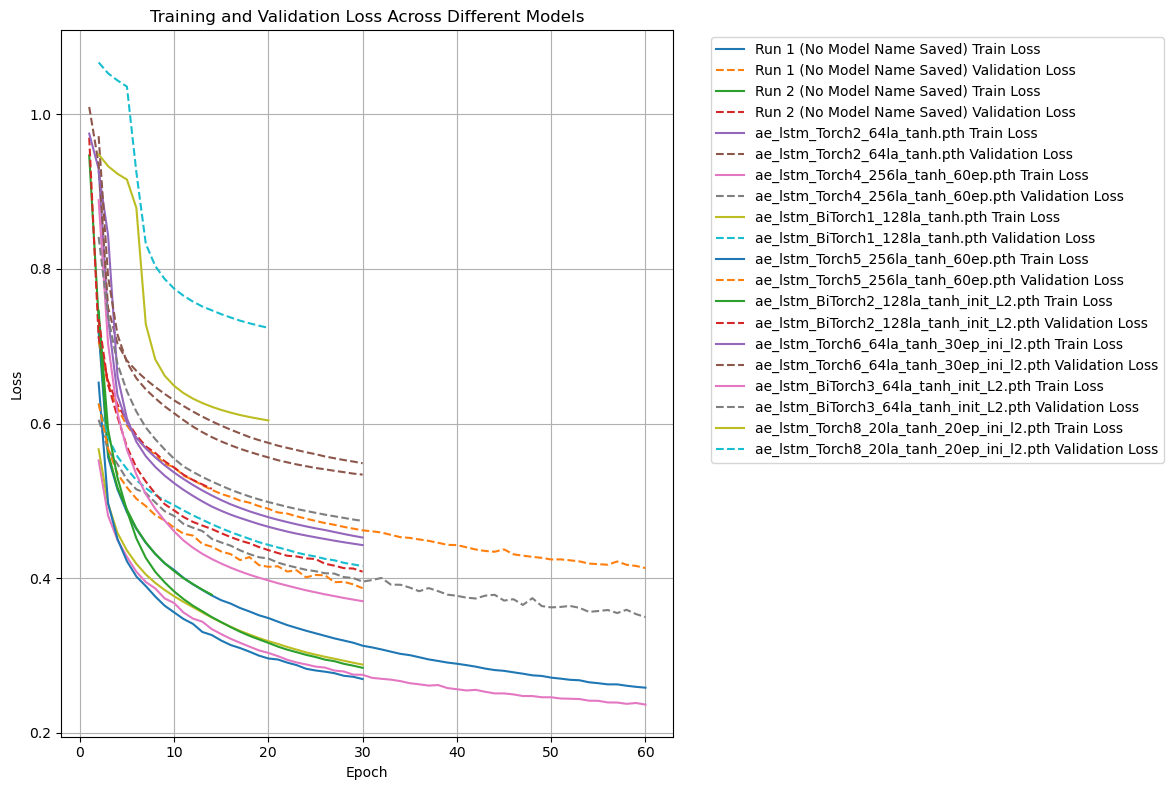

In [ ]:
#Plot results from results.loss file
import matplotlib.pyplot as plt
import re
import pandas as pd

# Read the content of the file
with open('Results loss.txt', 'r') as f:
    lines = f.readlines()

all_runs_info = [] # Will store dictionaries like {'model_name': '...', 'epochs_data': [...]}
current_epochs_data = [] # Data for the current run being parsed
current_model_name = None

for line in lines:
    line = line.strip()
    if line.startswith('Epoch'):
        # If 'Epoch 1/' is encountered and we have data from a previous run,
        # it means a new training run is starting. Save the previous run's data.
        if line.startswith('Epoch 1/') and current_epochs_data:
            # If current_model_name is None, it means the previous run did not have a SAVE line.
            # In this case, we assign a default name.
            if current_model_name is None:
                current_model_name = f"Run {len(all_runs_info) + 1} (No Model Name Saved)"
            all_runs_info.append({'model_name': current_model_name, 'epochs_data': current_epochs_data})
            current_epochs_data = []
            current_model_name = None # Reset for the new run

        # Extract epoch, train_loss, and val_loss
        match = re.search(r'Epoch (\d+)/\d+:\s+train_loss=([\d.]+),\s+val_loss=([\d.]+)', line)
        if match:
            epoch = int(match.group(1))
            train_loss = float(match.group(2))
            val_loss = float(match.group(3))
            current_epochs_data.append({
                'epoch': epoch,
                'train_loss': train_loss,
                'val_loss': val_loss
            })
    elif '[SAVE] Final model' in line:
        # Extract model name from the SAVE line
        match_save = re.search(r'saved_models/(.+?\.pth)', line)
        if match_save:
            current_model_name = match_save.group(1)
        
        # If we have epoch data for the current run, append it along with the model name.
        if current_epochs_data:
            all_runs_info.append({'model_name': current_model_name, 'epochs_data': current_epochs_data})
            current_epochs_data = [] # Reset for the next run
            current_model_name = None # Reset model name

# Handle the case for the very last run if it doesn't end with a [SAVE] line
# or if it's the only run and has no [SAVE] line.
if current_epochs_data:
    if current_model_name is None:
        current_model_name = f"Run {len(all_runs_info) + 1} (No Model Name Saved)"
    all_runs_info.append({'model_name': current_model_name, 'epochs_data': current_epochs_data})

plt.figure(figsize=(12, 8))

# Plot each run's data using the extracted model name for the legend
for run_info in all_runs_info:
    model_name = run_info['model_name']
    epochs_data = run_info['epochs_data']

    if epochs_data: # Ensure epochs_data is not empty before creating a DataFrame
        df = pd.DataFrame(epochs_data)
        plt.plot(df['epoch'], df['train_loss'], label=f'{model_name} Train Loss')
        plt.plot(df['epoch'], df['val_loss'], label=f'{model_name} Validation Loss', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Different Models')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Position legend outside the plot
plt.grid(True)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.savefig('loss_plot_with_model_names.png') # Save the generated plot with a new filename

print("Se ha generado el gráfico de pérdidas con los nombres de los modelos en la leyenda y se ha guardado como 'loss_plot_with_model_names.png'.")

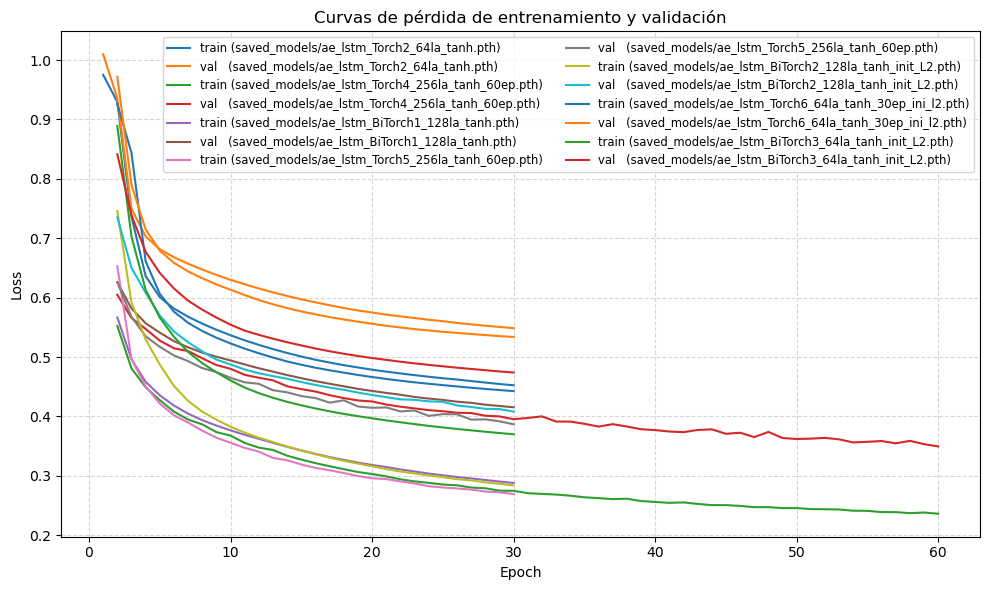

In [ ]:
#Plot results 
import re
import matplotlib.pyplot as plt

# 1) Leer el fichero de logs
with open('loss_results.txt', 'r', encoding='utf-8') as f:
    log_str = f.read()

# 2) Parsear por modelo
parts = re.split(r"\[SAVE\] Final model → ([^\n]+)", log_str)
data = {}
for i in range(1, len(parts), 2):
    model_name = parts[i].strip()
    segment    = parts[i-1]
    matches = re.findall(r"Epoch\s+(\d+)/\d+: train_loss=([\d\.]+), val_loss=([\d\.]+)", segment)
    if matches:
        epochs       = [int(e)       for e, _, _ in matches]
        train_losses = [float(t)     for _, t, _ in matches]
        val_losses   = [float(v)     for _, _, v in matches]
        data[model_name] = {'epoch': epochs, 'train': train_losses, 'val': val_losses}

# 3) Graficar todas las curvas en un único plot
plt.figure(figsize=(10, 6))
for model_name, d in data.items():
    plt.plot(d['epoch'], d['train'], label=f"train ({model_name})")
    plt.plot(d['epoch'], d['val'],   label=f"val   ({model_name})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Curvas de pérdida de entrenamiento y validación")
plt.legend(loc="upper right", fontsize="small", ncol=2)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



In [9]:
#Train backbone
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time


torch.backends.cudnn.benchmark = True

model = GaitAutoencoder(input_channels=321, seq_length=100, latent_dim=20).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer,
                              mode='min',
                              factor=0.5,     # reduce LR a la mitad
                              patience=3,     # tras 3 épocas sin mejora
                              #verbose=True
)
scaler    = GradScaler()

# Early stopping
best_val_loss   = float('inf')
epochs_no_imp   = 0
early_stop_patience = 5 

num_epochs = 10
for epoch in range(1, num_epochs+1):
    t0 = time.time()
    # ---- Entrenamiento ----
    model.train()
    total_train = 0.0
    for x, _ in train_loader:
        x = x.to(device, dtype=torch.float16)
        optimizer.zero_grad()
        with autocast():
            x_recon, _ = model(x)
            loss = criterion(x_recon, x)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_train += loss.item()
    avg_train = total_train / len(train_loader)

    # ---- Validación ----
    model.eval()
    total_val = 0.0
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.to(device, dtype=torch.float16)
            with autocast():
                x_recon, _ = model(x)
                total_val += criterion(x_recon, x).item()
    avg_val = total_val / len(val_loader)

    # ---- Scheduler step ----
    # Reduce LR si avg_val no mejora tras 'patience' épocas
    scheduler.step(avg_val)

    # ---- Early stopping check ----
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        epochs_no_imp = 0
        # Guarda el mejor modelo
        torch.save(model.state_dict(), "best_gait_autoencoder.pt")
    else:
        epochs_no_imp += 1
        if epochs_no_imp >= early_stop_patience:
            print(f"--> Early stopping at epoch {epoch}")
            break

    # ---- Logging ----
    epoch_time = time.time() - t0
    print(f"Epoch {epoch}/{num_epochs}  "
          f"Train: {avg_train:.4f}  Val: {avg_val:.4f}  "
          f"Time: {epoch_time:.1f}s  LR: {optimizer.param_groups[0]['lr']:.2e}")

print(f"Mejor val loss: {best_val_loss:.4f}")



/tmp/ipykernel_591534/3465785374.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = GradScaler()
/tmp/ipykernel_591534/3465785374.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_591534/3465785374.py:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10  Train: 0.9347  Val: 0.9699  Time: 210.3s  LR: 1.00e-04


/home/dmartinez/miniconda3/envs/inv_Di/lib/python3.10/site-packages/torch/utils/data/dataloader.py:750: UserWarning: Length of IterableDataset <AE_pipeline_pytorch.GaitBatchIterable object at 0x7450711a9330> was reported to be 760(when accessing len(dataloader)), but 761 samples have been fetched. For multiprocessing data-loading, this could be caused by not properly configuring the IterableDataset replica at each worker. Please see https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset for examples.
  warnings.warn(warn_msg)
/home/dmartinez/miniconda3/envs/inv_Di/lib/python3.10/site-packages/torch/utils/data/dataloader.py:750: UserWarning: Length of IterableDataset <AE_pipeline_pytorch.GaitBatchIterable object at 0x7450711aa980> was reported to be 165(when accessing len(dataloader)), but 166 samples have been fetched. For multiprocessing data-loading, this could be caused by not properly configuring the IterableDataset replica at each worker. Please see https://pyt

Epoch 2/10  Train: 0.8246  Val: 0.9521  Time: 226.8s  LR: 1.00e-04
Epoch 3/10  Train: 0.8137  Val: 0.9447  Time: 230.4s  LR: 1.00e-04
Epoch 4/10  Train: 0.8088  Val: 0.9411  Time: 211.3s  LR: 1.00e-04
Epoch 5/10  Train: 0.8054  Val: 0.9372  Time: 220.3s  LR: 1.00e-04
Epoch 6/10  Train: 0.8002  Val: 0.9310  Time: 226.6s  LR: 1.00e-04
Epoch 7/10  Train: 0.7937  Val: 0.9259  Time: 223.5s  LR: 1.00e-04
Epoch 8/10  Train: 0.7896  Val: 0.9230  Time: 219.0s  LR: 1.00e-04
Epoch 9/10  Train: 0.7870  Val: 0.9205  Time: 226.8s  LR: 1.00e-04
Epoch 10/10  Train: 0.7847  Val: 0.9187  Time: 222.8s  LR: 1.00e-04
Mejor val loss: 0.9187


# Train SemiSupervised

In [2]:
# === Config & seeds ===
import os, random
from pathlib import Path
import numpy as np
import torch

# Semillas
os.environ['PYTHONHASHSEED'] = '0'
random.seed(42); np.random.seed(42); torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Performance (si no requieres reproducibilidad estricta)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# (Ampere+): permitir TF32 para GEMMs
try:
    torch.set_float32_matmul_precision('high')
except Exception:
    pass


Device: cpu


In [3]:
# === Pérdidas ===
import torch.nn.functional as F
import torch

# --- pérdidas base ---
def consistency_loss(student_logits, teacher_logits):
    ps = F.softmax(student_logits, dim=-1)
    pt = F.softmax(teacher_logits.detach(), dim=-1)
    return F.mse_loss(ps, pt)

def supcon_loss(emb, labels, temperature=0.07):
    emb = F.normalize(emb, dim=-1)
    sim = torch.matmul(emb, emb.t()) / temperature
    labels = labels.contiguous().view(-1, 1)
    mask = torch.eq(labels, labels.t()).float().to(sim.device)
    logits_mask = torch.ones_like(mask) - torch.eye(mask.size(0), device=sim.device)
    mask = mask * logits_mask
    log_prob = sim - torch.logsumexp(sim + torch.log(logits_mask + 1e-12), dim=1, keepdim=True)
    mean_log_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-12)
    return -mean_log_pos.mean()

# --- wrappers usados en el loop ---
def loss_rec(out_recon, x): return F.mse_loss(out_recon, x)
def loss_group(logits, y):  return F.cross_entropy(logits, y)
def loss_supcon(proj, pid, temperature=0.07): return supcon_loss(proj, pid, temperature)
def loss_cons(student_logits, teacher_logits): return consistency_loss(student_logits, teacher_logits)
def loss_adv(nuis_logits, nuis): return F.cross_entropy(nuis_logits, nuis)


In [13]:
# === DataLoader para Zarr ===
from torch.utils.data import IterableDataset, DataLoader

class GaitBatchIterable(IterableDataset):
    """
    Lee un Zarr con clave 'data' de forma (N, 100, 326)
    y devuelve solo las 321 features: x ~ (B, 100, 321).
    """
    def __init__(self, store_path, batch_size, return_meta=False):
        self.store_path = str(Path(store_path))
        self.bs = int(batch_size)
        self.return_meta = bool(return_meta)

    def __iter__(self):
        import zarr, numpy as np
        from torch.utils.data import get_worker_info
        os.environ.setdefault("OMP_NUM_THREADS", "1")
        try:
            import numcodecs.blosc as nblosc
            nblosc.set_nthreads(1)  # 1 hilo por worker
        except Exception:
            pass

        p = Path(self.store_path)
        if not p.exists():
            raise FileNotFoundError(f"Zarr no encontrado: {p}")

        root = zarr.open_consolidated(str(p), mode="r") if (p / ".zmetadata").exists() else zarr.open_group(str(p), mode="r")
        key = "data" if "data" in root else root.array_keys()[0]
        z = root[key]  # (N,100,326)
        n = int(z.shape[0])

        wi = get_worker_info()
        rng = np.random.default_rng(wi.id if wi else None)

        starts = np.arange(0, n, self.bs, dtype=np.int64)
        rng.shuffle(starts)

        if wi:
            wid, nw = wi.id, wi.num_workers
            total = len(starts); per, rem = total // nw, total % nw
            beg = wid * per + min(wid, rem); end = beg + per + (1 if wid < rem else 0)
            starts = starts[beg:end]

        for s in starts:
            lo, hi = int(s), int(min(s + self.bs, n))
            data = z[lo:hi].astype("float32", copy=True)   # (B,100,326)
            feat = torch.from_numpy(data[:, :, :321])      # (B,100,321)
            yield feat


In [14]:
# Configuración del DataLoader
from pathlib import Path

# Hiperparámetros principales
micro_batch = 2048               # puedes probar 96 o 128 si no hay OOM
accum_steps = max(1, 256 // micro_batch)   # lote efectivo ≈ 256
num_workers = 0                   # prueba 8 si CPU/disco permiten
prefetch = 2
persistent = (num_workers > 0)
use_prefetch = (num_workers > 0)
print(f"micro_batch={micro_batch} | accum_steps={accum_steps} | workers={num_workers} | prefetch={prefetch}")

# Rutas
train_path = str(Path("train_cycles.zarr").resolve())
val_path   = str(Path("val_cycles.zarr").resolve())   # opcional, si lo tienes
test_path  = str(Path("test_cycles.zarr").resolve())  # opcional, si lo tienes

# DataLoaders
def make_loader(path):
    kwargs = dict(
        batch_size=None,
        num_workers=num_workers,
        pin_memory=False,                 # MPS: mejor False
        persistent_workers=persistent,
    )
    if use_prefetch:
        kwargs["prefetch_factor"] = prefetch

    return DataLoader(
        GaitBatchIterable(path, batch_size=micro_batch, return_meta=False),
        **kwargs
    )

train_loader = make_loader(train_path)

# Opcionales (solo si existen los .zarr)
val_loader  = make_loader(val_path)  if Path(val_path).exists()  else None
test_loader = make_loader(test_path) if Path(test_path).exists() else None



micro_batch=2048 | accum_steps=1 | workers=0 | prefetch=2


In [15]:
# Comprobación rápida del Zarr y DataLoader
import zarr
p = Path(train_path)
root = zarr.open_group(str(p), mode="r")
print("Arrays:", list(root.array_keys()))
print("shape data:", root["data"].shape)   # (N,100,326) esperado

x0 = next(iter(train_loader))
print("Primer batch shape:", x0.shape)     # (B,100,321)


Arrays: ['data']
shape data: (328122, 100, 326)
Primer batch shape: torch.Size([2048, 100, 321])


In [10]:
# === Weights and optimizer ===
from torch.optim import Adam, AdamW
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR

# Si tus clases viven en tu .py:
from AE_pipeline_pytorch import SemiSupAE, EMATeacher

model = SemiSupAE(steps=100, in_dim=321, latent=128, n_group=3, n_nuisance=None).to(device)
teacher = EMATeacher(model, ema=0.995)  # copia congelada con EMA

opt = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
warmup_steps = 1500
min_lr = 1e-5
scheduler = CosineAnnealingLR(opt, T_max=(20*1522), eta_min=min_lr)

scaler = GradScaler()

weights = dict(rec=1.0, group=1.0, supcon=0.5, cons=0.5, adv=0.1, pseudo_w=0.3)

# (Opcional) PyTorch 2.x: compilar
# model = torch.compile(model)
# teacher.teacher = torch.compile(teacher.teacher)


/tmp/ipykernel_1501827/1279206687.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [16]:
# === Checkpointing ===
from pathlib import Path
CKPT_DIR = Path("checkpoints_3groups"); CKPT_DIR.mkdir(exist_ok=True)
CKPT_PATH = CKPT_DIR / "semisupae_last.pt"

def save_ckpt(step, path=CKPT_PATH):
    torch.save({
        "model": model.state_dict(),
        "teacher": teacher.teacher.state_dict(),
        "opt": opt.state_dict(),
        "scaler": scaler.state_dict(),
        "step": step,
        "micro_batch": micro_batch,
        "accum_steps": accum_steps,
    }, CKPT_PATH)
    print(f"[ckpt] guardado en {CKPT_PATH} (step={step})")

def load_ckpt(path=CKPT_PATH):
    if not path.exists(): return 0
    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt["model"])
    teacher.teacher.load_state_dict(ckpt["teacher"])
    opt.load_state_dict(ckpt["opt"])
    scaler.load_state_dict(ckpt["scaler"])
    print(f"[ckpt] cargado desde {path} (step={ckpt.get('step',0)})")
    return ckpt.get("step", 0)

start_step = load_ckpt()


In [17]:
# === Setup logging por época (CSV + JSONL) ===
import os, csv, json, time
from pathlib import Path

RUN_DIR = Path("runs") / time.strftime("%Y%m%d_%H%M%S")
RUN_DIR.mkdir(parents=True, exist_ok=True)

CSV_PATH   = RUN_DIR / "metrics.csv"
JSONL_PATH = RUN_DIR / "metrics.jsonl"
FIELDS     = ["epoch", "global_step", "train_loss", "val_loss", "seconds"]

# cabecera CSV
if not CSV_PATH.exists():
    with open(CSV_PATH, "w", newline="") as f:
        csv.DictWriter(f, fieldnames=FIELDS).writeheader()

def log_epoch_row(epoch, global_step, train_loss, val_loss, seconds):
    row = dict(
        epoch=int(epoch),
        global_step=int(global_step),
        train_loss=float(train_loss),
        val_loss=float(val_loss),
        seconds=float(seconds),
    )
    # CSV
    with open(CSV_PATH, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=FIELDS)
        w.writerow(row); f.flush(); os.fsync(f.fileno())
    # JSONL
    with open(JSONL_PATH, "a") as f:
        f.write(json.dumps(row) + "\n"); f.flush(); os.fsync(f.fileno())

print("RUN_DIR:", RUN_DIR)

RUN_DIR: runs/20260127_131843


In [ ]:
# === Training loop (10 épocas, imprime train/val por época) ===
import contextlib, time
from torch.amp import autocast
from tqdm.auto import tqdm

def get_recon(out):
    # dict (semisup), tuple (AE) o tensor
    if isinstance(out, dict):  return out["recon"]
    if isinstance(out, tuple): return out[0]
    return out

def fmt_hms(s):
    s = int(s); h, s = divmod(s, 3600); m, s = divmod(s, 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

num_epochs  = 25
use_amp     = (device.type == "cuda")
global_step = start_step
best_val = float("inf")

opt.zero_grad(set_to_none=True)

overall_t0 = time.time()
ema_epoch_sec = None
ema_alpha = 0.3

for epoch in tqdm(range(1, num_epochs+1), desc="Epochs", leave=True):
    model.train()
    if device.type == "cuda":
        torch.cuda.reset_peak_memory_stats()
    epoch_t0 = time.time()
    train_loss_sum = 0.0
    n_train_batches = 0

    # barra de batches de entrenamiento
    pbar = tqdm(train_loader, desc=f"Train e{epoch:02d}", leave=False, mininterval=0.5)
    for i, x in enumerate(pbar, start=1):
        x = x.to(device, non_blocking=True)

        ctx = autocast(device_type="cuda", dtype=torch.bfloat16) if use_amp else contextlib.nullcontext()
        with ctx:
            out_s = model(x, return_all=True)
            with torch.no_grad():
                out_t = teacher.teacher(x, return_all=True)
            loss_step = (
                weights['rec']  * loss_rec(out_s['recon'], x) +
                weights['cons'] * loss_cons(out_s['logits'], out_t['logits'])
            )
            loss_for_backward = loss_step / accum_steps

        scaler.scale(loss_for_backward).backward()

        if (i % accum_steps) == 0:
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(opt)
            scaler.update()
            opt.zero_grad(set_to_none=True)
            teacher.update(model)

        global_step += 1
        train_loss_sum += loss_step.item()
        n_train_batches += 1

        # muestra loss instantánea en la barra
        pbar.set_postfix({"loss": f"{loss_step.item():.4f}"})

    # --- fin de época: promedio train ---
    train_loss = train_loss_sum / max(1, n_train_batches)

    # --- validación con barra (opcional) ---
    model.eval()
    val_loss_sum = 0.0
    n_val_batches = 0
    with torch.no_grad():
        vctx = autocast(device_type="cuda") if use_amp else contextlib.nullcontext()
        vbar = tqdm(val_loader, desc=f"Val   e{epoch:02d}", leave=False, mininterval=0.5)
        for vb in vbar:
            xv = vb.to(device, non_blocking=True) if torch.is_tensor(vb) else vb[0].to(device, non_blocking=True)
            with vctx:
                out_v = model(xv)
            recon_v = get_recon(out_v)
            l = loss_rec(recon_v, xv).item()
            val_loss_sum += l
            n_val_batches += 1
            vbar.set_postfix({"loss": f"{l:.4f}"})

    val_loss = val_loss_sum / max(1, n_val_batches)

    # tiempos y ETA total
    epoch_secs = time.time() - epoch_t0
    ema_epoch_sec = epoch_secs if ema_epoch_sec is None else (ema_alpha*epoch_secs + (1-ema_alpha)*ema_epoch_sec)
    eta_secs = ema_epoch_sec * (num_epochs - epoch)

    # línea resumen (una por época)
    print(
        f"Epoch {epoch:02d}/{num_epochs} | "
        f"train_loss={train_loss:.6f} | val_loss={val_loss:.6f} | "
        f"time/epoch={fmt_hms(epoch_secs)} | ETA total={fmt_hms(eta_secs)}"
    )

    # logging a archivos si lo tienes configurado
    try:
        log_epoch_row(epoch, global_step, train_loss, val_loss, epoch_secs)
    except NameError:
        pass

    # checkpoints solo fin de época (best + last dentro de RUN_DIR si lo usas)
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), RUN_DIR / "semisupae_best.pt")
        print(f"[ckpt] mejor → {RUN_DIR/'semisupae_best.pt'} (val={best_val:.6f})")
    save_ckpt(global_step, path=RUN_DIR / "semisupae_last.pt")

# fin
torch.save(model.state_dict(), RUN_DIR / "semisupae_last_only_model.pt")
total_secs = time.time() - overall_t0
print(f"[fin] mejor val={best_val:.6f} | total={fmt_hms(total_secs)} | carpeta: {RUN_DIR}")








Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 01/25 | train_loss=0.981230 | val_loss=0.908504 | time/epoch=00:14:46 | ETA total=05:54:45


Epochs:   4%|▍         | 1/25 [14:48<5:55:17, 888.21s/it]

[ckpt] mejor → runs/20251110_190640/semisupae_best.pt (val=0.908504)
[ckpt] guardado en checkpoints_3groups/semisupae_last.pt (step=81)


Epoch 02/25 | train_loss=0.958554 | val_loss=0.892294 | time/epoch=00:13:07 | ETA total=05:28:30


Epochs:   8%|▊         | 2/25 [27:55<5:17:46, 829.00s/it]

[ckpt] mejor → runs/20251110_190640/semisupae_best.pt (val=0.892294)
[ckpt] guardado en checkpoints_3groups/semisupae_last.pt (step=162)


Epoch 03/25 | train_loss=0.924027 | val_loss=0.822357 | time/epoch=00:13:01 | ETA total=05:05:57
[ckpt] mejor → runs/20251110_190640/semisupae_best.pt (val=0.822357)


Epochs:  12%|█▏        | 3/25 [41:02<4:56:55, 809.79s/it]

[ckpt] guardado en checkpoints_3groups/semisupae_last.pt (step=243)


Epoch 04/25 | train_loss=0.764094 | val_loss=0.689118 | time/epoch=00:12:53 | ETA total=04:45:37


Epochs:  16%|█▌        | 4/25 [53:56<4:38:27, 795.59s/it]

[ckpt] mejor → runs/20251110_190640/semisupae_best.pt (val=0.689118)
[ckpt] guardado en checkpoints_3groups/semisupae_last.pt (step=324)


Epoch 05/25 | train_loss=0.672206 | val_loss=0.650680 | time/epoch=00:12:56 | ETA total=04:28:06


Epochs:  20%|██        | 5/25 [1:06:53<4:22:59, 788.95s/it]

[ckpt] mejor → runs/20251110_190640/semisupae_best.pt (val=0.650680)
[ckpt] guardado en checkpoints_3groups/semisupae_last.pt (step=405)


Epoch 06/25 | train_loss=0.631274 | val_loss=0.627249 | time/epoch=00:12:58 | ETA total=04:12:14
[ckpt] mejor → runs/20251110_190640/semisupae_best.pt (val=0.627249)


Epochs:  24%|██▍       | 6/25 [1:19:52<4:08:44, 785.51s/it]

[ckpt] guardado en checkpoints_3groups/semisupae_last.pt (step=486)


In [ ]:
# === Training loop ===
model.train()
opt.zero_grad(set_to_none=True)

import time
torch.cuda.reset_peak_memory_stats()
t0 = time.perf_counter()
report_every = 50
ckpt_every = 500

try:
    for step, x in enumerate(train_loader, start=start_step+1):
        x = x.to(device, non_blocking=True)

        with autocast(dtype=torch.float16):
            out_s = model(x, return_all=True)
            with torch.no_grad():
                out_t = teacher.teacher(x, return_all=True)

            # pérdidas activas (sin etiquetas): reconstrucción + consistencia
            L = 0.0
            L += weights['rec']  * loss_rec(out_s['recon'], x)
            L += weights['cons'] * loss_cons(out_s['logits'], out_t['logits'])
            L /= accum_steps

        scaler.scale(L).backward()

        if step % accum_steps == 0:
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(opt)
            scaler.update()
            opt.zero_grad(set_to_none=True)
            teacher.update(model)

        if step % report_every == 0:
            t1 = time.perf_counter()
            avg = (t1 - t0) / report_every
            print(f"{step} batches: {avg:.3f}s/batch | VRAM pico={torch.cuda.max_memory_allocated()/1e9:.2f} GB")
            t0 = time.perf_counter()

        if step % ckpt_every == 0:
            save_ckpt(step)

except KeyboardInterrupt:
    print("Interrumpido por usuario — guardando checkpoint…")
    save_ckpt(step)
except Exception as e:
    print("Error durante entrenamiento — guardando checkpoint…", repr(e))
    save_ckpt(step)
    raise
finally:
    save_ckpt(step)


/tmp/ipykernel_873345/2622560769.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):


50 batches: 1.729s/batch | VRAM pico=0.33 GB
100 batches: 1.296s/batch | VRAM pico=0.33 GB
150 batches: 1.469s/batch | VRAM pico=0.33 GB
200 batches: 1.470s/batch | VRAM pico=0.33 GB
250 batches: 1.170s/batch | VRAM pico=0.33 GB
300 batches: 1.304s/batch | VRAM pico=0.33 GB
350 batches: 1.345s/batch | VRAM pico=0.33 GB
400 batches: 1.096s/batch | VRAM pico=0.33 GB
450 batches: 1.266s/batch | VRAM pico=0.33 GB
500 batches: 0.985s/batch | VRAM pico=0.33 GB
[ckpt] guardado en checkpoints/semisupae_last.pt (step=500)
550 batches: 1.174s/batch | VRAM pico=0.33 GB
600 batches: 1.227s/batch | VRAM pico=0.33 GB
650 batches: 1.189s/batch | VRAM pico=0.33 GB
700 batches: 1.008s/batch | VRAM pico=0.33 GB
750 batches: 1.118s/batch | VRAM pico=0.33 GB
800 batches: 1.063s/batch | VRAM pico=0.33 GB
850 batches: 1.049s/batch | VRAM pico=0.33 GB
900 batches: 1.109s/batch | VRAM pico=0.33 GB
950 batches: 0.988s/batch | VRAM pico=0.33 GB
1000 batches: 1.214s/batch | VRAM pico=0.33 GB
[ckpt] guardado en c

In [ ]:
# === Validación rápida (MSE) ===
model.eval()
val_mse = 0.0; n_batches = 0
with torch.no_grad(), autocast(dtype=torch.float16):
    for x in val_loader:
        x = x.to(device, non_blocking=True)
        out = model(x)              # por compatibilidad: puede devolver tupla
        recon = out[0] if isinstance(out, tuple) else out['recon'] if isinstance(out, dict) else out
        val_mse += F.mse_loss(recon, x).item()
        n_batches += 1
val_mse /= max(1, n_batches)
print("Val MSE:", val_mse)
model.train()


In [6]:
from sklearn.metrics import mean_absolute_error, r2_score

device = torch.device('cpu')
if not torch.cuda.is_available() or device.type == 'cpu':
    torch.Tensor.pin_memory = lambda self: self

In [7]:
#Evaluate metrics 

model = LSTMAutoencoder(n_timesteps=100, n_vars=321, latent_dim=128).to(device)

# Load state dict and remove '_orig_mod.' prefix if present
state_dict = torch.load("saved_models/ae_lstm_Torch1.pth", map_location="cpu")
clean_state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}
model.load_state_dict(clean_state_dict)

model.eval()

metrics = evaluate_autoencoder_streaming(model, train_loader, device)
print(metrics)



NotImplementedError: Subclasses of Dataset should implement __getitem__.

In [ ]:
model.eval()
mse = torch.nn.MSELoss(reduction='none')

all_scores = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        recon = model(x)                       # (B, T, 321)
        # Si quieres comparar recon vs y, quizá tu función `evaluate_and_detect`
        # espera (x, y) y devuelve errores. Sino:
        # ejemplo de score: media de MSE por variable
        loss = mse(recon, x).mean(dim=(1,2))   # reconstrucción de x vs x
        # o si tu supervisión es recon vs y:
        # loss = mse(recon, y).mean(dim=(1,2))
        all_scores.append(loss.cpu())

all_scores = torch.cat(all_scores)
print("Test MSE (batch-wise):", all_scores.mean().item())


# SuPAE V2 

In [1]:
# Imports 
# -------------------------
import os, random, sys, time, json
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import DataLoader
from collections import defaultdict
import torch.nn.functional as F




SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

import torch.nn.functional as F
import torch.optim as optim

# -------------------------
# Device selection (CUDA > MPS > CPU)
# -------------------------
def pick_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

device = pick_device()
print("Using device:", device)

# -------------------------
# Import your pipeline
# -------------------------
os.chdir('..')
sys.path.insert(0, os.getcwd())

from AE_pipeline_pytorch import (
    MultiSubjectGaitBatchIterable,
    SemiSupAE,
    EMATeacher,
    train_step,
)



Using device: mps
Using device: cpu
Using device: cpu


In [12]:
# DataLoader 
# -------------------------
train_path = "train_cycles.zarr"
val_path   = "val_cycles.zarr"

train_slices_json = "train_subject_slices.json"
val_slices_json   = "val_subject_slices.json"

patients_per_batch  = 16
patients_per_batch_val  = 9
patients_per_batch_test  = 17
samples_per_patient = 8

num_workers = 0   # Mac/MPS más estable con 0

train_ds = MultiSubjectGaitBatchIterable(
        store_path="train_cycles.zarr",
        subject_slices_json="train_subject_slices.json",
        patients_per_batch=patients_per_batch,
        samples_per_patient=samples_per_patient,
        return_meta=True,
        shuffle_subjects=True,
        seed=SEED,
        feat_dim=321,
        t_steps=100,
        meta_dim=5,
        infinite=True,              # útil para entrenamiento por épocas sin preocuparse del final
        require_full_batch=True,     # asegura batches completos de pacientes+ejemplos
    )


train_loader = DataLoader(
    train_ds,
    batch_size=None,
    num_workers=0,
    pin_memory=False,              # MPS: False
    persistent_workers=False,
)

val_ds = MultiSubjectGaitBatchIterable(
        store_path="val_cycles.zarr",
        subject_slices_json="val_subject_slices.json", 
        patients_per_batch=patients_per_batch_val,
        samples_per_patient=samples_per_patient,
        return_meta=True,
        shuffle_subjects=False,   
        seed=42,
        feat_dim=321,
        t_steps=100,
        meta_dim=5,
        infinite=False,
        require_full_batch=True,
    )

val_loader = DataLoader(
    val_ds,
    batch_size=None,
    num_workers=0,
    pin_memory=False,
)


test_ds = MultiSubjectGaitBatchIterable(
        store_path="test_cycles.zarr",
        subject_slices_json="test_subject_slices.json", 
        patients_per_batch=patients_per_batch_test,
        samples_per_patient=samples_per_patient,
        return_meta=True,
        shuffle_subjects=False,   
        seed=42,
        feat_dim=321,
        t_steps=100,
        meta_dim=5,
        infinite=False,
        require_full_batch=True,
    )

test_loader = DataLoader(
    test_ds,
    batch_size=None,
    num_workers=0,
    pin_memory=False,
)

x, meta0, cycle_id = next(iter(test_loader))
print("x:", x.shape)
print("meta0:", meta0.shape)
print("cycle_id:", cycle_id.shape)

x: torch.Size([136, 100, 321])
meta0: torch.Size([136, 5])
cycle_id: torch.Size([136])


In [ ]:
#  OPCIONAL Contar el número de sujetos únicos en train, val y test usando los archivos de slices por sujeto
def count_unique_subjects(slices_json_path):
    with open(slices_json_path, "r") as f:
        slices = json.load(f)
    # Asume que las claves del JSON son los IDs de los sujetos (como string o int)
    subject_ids = list(slices.keys())
    print(f"{slices_json_path}: {len(subject_ids)} subjects")
    print("First 10 subject IDs:", subject_ids[:10])
    return subject_ids

train_subjects = count_unique_subjects("train_subject_slices.json")
val_subjects   = count_unique_subjects("val_subject_slices.json")
test_subjects  = count_unique_subjects("test_subject_slices.json") if os.path.exists("test_subject_slices.json") else []

print(f"Total unique subjects - Train: {len(train_subjects)}, Val: {len(val_subjects)}, Test: {len(test_subjects)}")


train_subject_slices.json: 90 subjects
First 10 subject IDs: ['11', '15', '6', '25', '37', '27', '35', '20', '32', '30']
val_subject_slices.json: 18 subjects
First 10 subject IDs: ['26', '4', '28', '5', '63', '19', '9', '157', '137', '102']
test_subject_slices.json: 17 subjects
First 10 subject IDs: ['18', '21', '2', '8', '107', '119', '120', '125', '13', '104']
Total unique subjects - Train: 90, Val: 18, Test: 17


In [8]:
# Meta indexes 
META_SUBJECT = 0
META_GROUP   = 1
META_DAY     = 2

def pack_batch(x, meta0):
    patient_id = meta0[:, META_SUBJECT].long()
    y_group    = meta0[:, META_GROUP].long()

    # Mapear Day a {0,1}
    day_raw = meta0[:, META_DAY].long()
    day = (day_raw - day_raw.min()).long()  # asegura 0/1

    batch = {
        "x": x.to(device),
        "y_group": y_group.to(device),
        "patient_id": patient_id.to(device),
        "nuis": day.to(device)  # <- adversarial target
    }

    return batch


In [4]:
# Configuración del modelo y entrenamiento
n_group = 3
n_nuisance = 2  # Day 1 vs Day 2

model = SemiSupAE(
    steps=100,
    in_dim=321,
    latent=64,
    n_group=n_group,
    n_nuisance=n_nuisance
).to(device)

teacher = EMATeacher(model, ema=0.995)

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Pesos científicos recomendados
weights = dict(
    rec=1.0,
    group=1.0,
    supcon=0.0,   # <- APAGADO (evita identidad)
    cons=0.0,
    adv=0.0,      # <- fuerza invariancia a Day
    pseudo_w=0.0
)

pseudo_thresh = 0.95
steps_per_epoch = 40
val_steps = 20

In [5]:
# Funciones de entrenamiento y evaluación por época
# def train_epoch(loader, epoch_idx, steps_per_epoch=1000, ds=None, debug_steps=0):
#     model.train()

#     # Deterministic shuffling for IterableDataset (if supported)
#     if ds is not None and hasattr(ds, "set_epoch"):
#         ds.set_epoch(epoch_idx)
#     elif hasattr(loader, "dataset") and hasattr(loader.dataset, "set_epoch"):
#         loader.dataset.set_epoch(epoch_idx)

#     loss_sum = 0.0
#     n = 0

#     for step, batch_items in enumerate(loader, start=1):
#         if step > steps_per_epoch:
#             break

#         # Support (x, meta0, cycle_id) or (x, meta0)
#         if isinstance(batch_items, (tuple, list)):
#             if len(batch_items) == 3:
#                 x, meta0, _ = batch_items
#             elif len(batch_items) == 2:
#                 x, meta0 = batch_items
#             else:
#                 x = batch_items[0]
#                 meta0 = None
#         else:
#             x = batch_items
#             meta0 = None

#         # Debug printing (ONLY for first epoch & first debug_steps)
#         if debug_steps and epoch_idx == 1 and step <= debug_steps and meta0 is not None:
#             try:
#                 # tensor/ndarray case
#                 subj_col = meta0[:, 0]
#                 if hasattr(subj_col, "detach"):
#                     subj_ids = subj_col.detach().cpu().tolist()
#                 else:
#                     subj_ids = subj_col.tolist()
#             except Exception:
#                 # list-of-lists case
#                 subj_ids = [row[0] for row in meta0]

#             unique_subjects = sorted(set(int(s) for s in subj_ids))
#             print(f"[Train Epoch {epoch_idx}, Batch {step}] {len(unique_subjects)} unique subjects: {unique_subjects}")

#         batch = pack_batch(x, meta0)

#         optimizer.zero_grad(set_to_none=True)

#         loss = train_step(
#             batch=batch,
#             model=model,
#             teacher=teacher,
#             optimizer=optimizer,
#             weights=weights,
#             augment_fn=lambda x: x,
#             pseudo_thresh=pseudo_thresh
#         )

#         # Normalize loss to float
#         if isinstance(loss, dict):
#             lv = loss.get("loss", 0.0)
#         else:
#             lv = loss

#         if hasattr(lv, "item"):
#             loss_value = float(lv.item())
#         else:
#             loss_value = float(lv)

#         loss_sum += loss_value
#         n += 1

#     return loss_sum / max(1, n)


def train_epoch(loader, epoch_idx, steps_per_epoch=1000, debug_steps=0):
    model.train()
    if "train_ds" in globals() and hasattr(train_ds, "set_epoch"):
        train_ds.set_epoch(epoch_idx)

    sums = defaultdict(float)
    n = 0

    for step, batch_items in enumerate(loader, start=1):
        if step > steps_per_epoch:
            break

        # unpack...
        if isinstance(batch_items, (tuple, list)):
            x, meta0 = batch_items[0], (batch_items[1] if len(batch_items) >= 2 else None)
        else:
            x, meta0 = batch_items, None

        batch = pack_batch(x, meta0)

        out = train_step(
            batch=batch, model=model, teacher=teacher, optimizer=optimizer,
            weights=weights, augment_fn=lambda x: x,
            pseudo_thresh=pseudo_thresh
        )

        # acumula
        for k, v in out.items():
            sums[k] += float(v)
        n += 1

        if debug_steps and step <= debug_steps:
            print(f"[Train Epoch {epoch_idx}, step {step}] " +
                  ", ".join([f"{k}={out[k]:.4f}" for k in ["loss","rec","group","supcon","cons","adv"] if k in out]))

    means = {k: sums[k]/max(1,n) for k in sums}
    return means



@torch.no_grad()
def eval_epoch(
    loader,
    val_steps=40,
    adv_weight=0.2,
    rec_weight=1.0,
    group_weight=1.0,
    epoch_idx=None,
    ds=None,   # <- PASA AQUÍ val_ds si quieres asegurar set_epoch
):
    """
    Returns dict with:
      - val_group_ce, val_rec_mse, val_adv_ce
      - val_group_acc, val_day_acc
      - val_total = rec_weight*rec_mse + group_weight*group_ce + adv_weight*adv_ce

    NOTE: This assumes adv_ce is a *penalty* term (added). If you use GRL/adversarial
    maximization during training, val_total is still a useful metric but not the exact objective.
    """
    model.eval()

    # Robust epoch control for iterable datasets
    if epoch_idx is not None:
        if ds is not None and hasattr(ds, "set_epoch"):
            ds.set_epoch(epoch_idx)
        else:
            # fallback: try common places
            if hasattr(loader, "dataset") and hasattr(loader.dataset, "set_epoch"):
                loader.dataset.set_epoch(epoch_idx)

    sum_group_ce = 0.0
    sum_rec_mse  = 0.0
    sum_adv_ce   = 0.0

    n_batches = 0
    n_samples = 0

    correct_group = 0
    correct_day   = 0
    n_day_samples = 0

    for step, batch_items in enumerate(loader, start=1):
        if step > val_steps:
            break

        # Support (x, meta0, cycle_id) or (x, meta0) or x
        if isinstance(batch_items, (tuple, list)):
            if len(batch_items) == 3:
                x, meta0, _ = batch_items
            elif len(batch_items) == 2:
                x, meta0 = batch_items
            else:
                x = batch_items[0]
                meta0 = None
        else:
            x = batch_items
            meta0 = None

        batch = pack_batch(x, meta0)
        out = model(batch["x"], return_all=True)

        # -------- Group CE + acc --------
        logits_g = out["logits"]
        y_g = batch["y_group"]
        group_ce = F.cross_entropy(logits_g, y_g)
        sum_group_ce += float(group_ce.item())

        pred_g = logits_g.argmax(dim=-1)
        correct_group += int((pred_g == y_g).sum().item())

        # -------- Recon MSE --------
        recon = out.get("recon", None)
        if recon is not None:
            rec_mse = F.mse_loss(recon, batch["x"])
            sum_rec_mse += float(rec_mse.item())

        # -------- Nuisance/day CE + acc --------
        y_day = batch.get("nuis", batch.get("day", None))
        nuis_logits = out.get("nuis_logits", None)

        if (
            weights.get("adv", 0.0) > 0
            and y_day is not None
            and nuis_logits is not None
            and getattr(model, "use_nuis", False)
        ):
            adv_ce = F.cross_entropy(nuis_logits, y_day)
            sum_adv_ce += float(adv_ce.item())

            pred_day = nuis_logits.argmax(dim=-1)
            correct_day += int((pred_day == y_day).sum().item())
            n_day_samples += int(y_day.numel())


        bs = int(batch["x"].shape[0])
        n_samples += bs
        n_batches += 1

    group_ce_mean = sum_group_ce / max(1, n_batches)
    rec_mse_mean  = sum_rec_mse  / max(1, n_batches)
    adv_ce_mean   = sum_adv_ce   / max(1, n_batches)

    metrics = {
        "val_group_ce": group_ce_mean,
        "val_rec_mse":  rec_mse_mean,
        "val_adv_ce":   adv_ce_mean,
        "val_group_acc": correct_group / max(1, n_samples),
        "val_day_acc": (correct_day / n_day_samples) if n_day_samples > 0 else None,
    }

    metrics["val_total"] = (
        rec_weight   * rec_mse_mean +
        group_weight * group_ce_mean +
        adv_weight   * adv_ce_mean
    )

    return metrics


@torch.no_grad()
def eval_by_subject(
    loader,
    val_steps=None,
    n_groups=None,
    min_subjects=18,
    max_steps=80,
    epoch_idx=None,
    ds=None,   # <- PASA AQUÍ val_ds si quieres asegurar set_epoch
):
    """
    Subject-level evaluation by mean-logits pooling across cycles.
    Iterates until seeing at least min_subjects subjects or reaching max_steps.
    """

    model.eval()

    # Robust epoch control (so val subject coverage changes across epochs)
    if epoch_idx is not None:
        if ds is not None and hasattr(ds, "set_epoch"):
            ds.set_epoch(epoch_idx)
        else:
            if hasattr(loader, "dataset") and hasattr(loader.dataset, "set_epoch"):
                loader.dataset.set_epoch(epoch_idx)

    subj_sum_logits = {}
    subj_count = defaultdict(int)
    subj_true = {}

    # single pass over loader with early stopping
    for step, batch_items in enumerate(loader, start=1):
        if val_steps is not None and step > val_steps:
            break
        if step > max_steps:
            break

        if isinstance(batch_items, (tuple, list)):
            if len(batch_items) == 3:
                x, meta0, _ = batch_items
            elif len(batch_items) == 2:
                x, meta0 = batch_items
            else:
                x = batch_items[0]
                meta0 = None
        else:
            x = batch_items
            meta0 = None

        batch = pack_batch(x, meta0)
        out = model(batch["x"], return_all=True)
        logits = out["logits"].detach().to("cpu")
        y_g = batch["y_group"].detach().to("cpu")

        # get subject ids
        if "subject_id" in batch:
            subj = batch["subject_id"].detach().to("cpu")
        else:
            if meta0 is None:
                raise ValueError("Need subject identifiers in batch['subject_id'] or meta0[:,0].")
            subj = meta0[:, 0]
            if not torch.is_tensor(subj):
                subj = torch.tensor(subj)
            subj = subj.detach().to("cpu")

        B = logits.shape[0]
        for i in range(B):
            sid = int(subj[i].item())

            if sid not in subj_sum_logits:
                subj_sum_logits[sid] = logits[i].clone()
            else:
                subj_sum_logits[sid] += logits[i]

            subj_count[sid] += 1

            yi = int(y_g[i].item())
            if sid not in subj_true:
                subj_true[sid] = yi
            elif yi != subj_true[sid]:
                raise ValueError(
                    f"Inconsistent y_group for subject {sid}: "
                    f"seen {subj_true[sid]} then {yi}. "
                    "Check split integrity / meta packing."
                )

        if len(subj_sum_logits) >= min_subjects:
            break

    seen_ids = sorted(subj_sum_logits.keys())
    n_subj = len(seen_ids)

    correct = 0
    group_total = defaultdict(int)
    group_correct = defaultdict(int)

    for sid, sumlog in subj_sum_logits.items():
        pred = int((sumlog / max(1, subj_count[sid])).argmax().item())
        true_g = subj_true[sid]
        group_total[true_g] += 1
        if pred == true_g:
            correct += 1
            group_correct[true_g] += 1

    subject_acc = correct / max(1, n_subj)

    # Balanced subject acc
    per_class_acc = {}
    if n_groups is not None:
        for g in range(n_groups):
            tot = group_total.get(g, 0)
            per_class_acc[g] = (group_correct.get(g, 0) / tot) if tot > 0 else 0.0
        balanced_subject_acc = sum(per_class_acc.values()) / max(1, n_groups)
    else:
        for g, tot in group_total.items():
            per_class_acc[g] = (group_correct[g] / tot) if tot > 0 else 0.0
        balanced_subject_acc = (sum(per_class_acc.values()) / len(per_class_acc)) if per_class_acc else 0.0

    avg_cycles_per_subject = sum(subj_count.values()) / max(1, n_subj)

    return {
        "n_subjects": n_subj,
        "seen_subject_ids": seen_ids,
        "subject_acc": subject_acc,
        "avg_cycles_per_subject": avg_cycles_per_subject,
        "per_class_subject_acc": per_class_acc,
        "balanced_subject_acc": balanced_subject_acc,
    }


In [6]:
# Training loop con métricas detalladas por época
num_epochs = 8
best_val = float("inf")

rec = weights['rec']
group = weights['group']
adv = weights['adv']

for epoch in range(1, num_epochs+1):

    t0 = time.time()

    # ---- TRAIN ----
#     train_loss = train_epoch(
#     train_loader,
#     epoch_idx=epoch,
#     steps_per_epoch=300,
#     ds=train_ds,
#     debug_steps=5   # pon 0 después de verificar
# )
    train_m = train_epoch(train_loader, epoch_idx=epoch, steps_per_epoch=steps_per_epoch)
    train_loss = train_m["loss"]
    # print("train parts:", {
    #     k: {
    #         "value": round(train_m[k], 4),
    #         "weight": weights.get(k, None),
    #         "weighted": round(train_m[k] * weights.get(k, 0.0), 4)
    #     }
    #     for k in ["rec", "group", "supcon", "cons", "adv"]
    #     if k in train_m
    # })

    print(f"train_loss={train_m['loss']:.4f} rec={train_m['rec']:.4f} group={train_m['group']:.4f} "
      f"supcon={train_m['supcon']:.4f} cons={train_m['cons']:.4f} adv={train_m['adv']:.4f}")
    #print("weights:", weights)
    #print("model.use_nuis:", model.use_nuis)

    # ---- VALIDATION (cycle-level) ----
    val_metrics = eval_epoch(
        val_loader,
        val_steps=40,
        epoch_idx=epoch,
        ds=val_ds
    )

    # ---- VALIDATION (subject-level) ----
    val_subj = eval_by_subject(
        val_loader,
        val_steps=40,
        max_steps=80,
        min_subjects=18,
        epoch_idx=epoch,
        ds=val_ds,
        n_groups=3
    )

    val_loss = val_metrics["val_total"]

    # ---- Save best ----
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "best_model.pt")

    dt = time.time() - t0

    print(
        f"Epoch {epoch:02d}/{num_epochs} | "
        f"train={train_loss:.5f} | "
        f"val_total={val_metrics['val_total']:.5f} | "
        f"val_group_ce={val_metrics['val_group_ce']:.5f} | "
        f"val_rec_mse={val_metrics['val_rec_mse']:.5f} | "
        f"val_adv_ce={val_metrics['val_adv_ce']:.5f} | "
        f"val_group_acc={val_metrics['val_group_acc']:.3f} | "
        f"val_subject_acc={val_subj['subject_acc']:.3f} | "
        f"balanced_subject_acc={val_subj['balanced_subject_acc']:.3f} | "
        f"n_subjects={val_subj['n_subjects']} | "
        f"avg_cycles_per_subject={val_subj['avg_cycles_per_subject']:.2f} | "
        f"val_day_acc={val_metrics['val_day_acc']} | "
        f"time={dt:.1f}s"
    )

    #print(f"seen_subject_ids: {val_subj['seen_subject_ids'][:10]} ...")




train_loss=1.7122 rec=1.0428 group=0.6694 supcon=0.0000 cons=0.0237 adv=0.0000
Epoch 01/8 | train=1.71222 | val_total=1.51691 | val_group_ce=0.51721 | val_rec_mse=0.99970 | val_adv_ce=0.00000 | val_group_acc=0.396 | val_subject_acc=0.389 | balanced_subject_acc=0.352 | n_subjects=18 | avg_cycles_per_subject=8.00 | val_day_acc=None | time=30.4s
Epoch 01/8 | train=1.71222 | val_total=1.51691 | val_group_ce=0.51721 | val_rec_mse=0.99970 | val_adv_ce=0.00000 | val_group_acc=0.396 | val_subject_acc=0.389 | balanced_subject_acc=0.352 | n_subjects=18 | avg_cycles_per_subject=8.00 | val_day_acc=None | time=30.4s
train_loss=1.5039 rec=1.0295 group=0.4744 supcon=0.0000 cons=0.0421 adv=0.0000
train_loss=1.5039 rec=1.0295 group=0.4744 supcon=0.0000 cons=0.0421 adv=0.0000
Epoch 02/8 | train=1.50391 | val_total=1.77560 | val_group_ce=0.55098 | val_rec_mse=1.22462 | val_adv_ce=0.00000 | val_group_acc=0.340 | val_subject_acc=0.333 | balanced_subject_acc=0.305 | n_subjects=18 | avg_cycles_per_subject=8.

In [6]:
import numpy as np
import torch
from collections import defaultdict

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    normalized_mutual_info_score,
    adjusted_rand_score,
    silhouette_score
)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

@torch.no_grad()
def extract_latents(loader, model, pack_batch, max_steps=None, device=None):
    """
    Extract per-cycle latents z, groups, subject_ids from a loader.
    Returns:
      Z: (N, latent)
      y_group: (N,)
      subj: (N,)
      logits: (N, n_groups)
    """
    model.eval()
    Z_list, yg_list, sid_list, log_list = [], [], [], []

    for step, batch_items in enumerate(loader, start=1):
        if max_steps is not None and step > max_steps:
            break

        # parse batch_items (same logic you've been using)
        if isinstance(batch_items, (tuple, list)):
            if len(batch_items) == 3:
                x, meta0, _ = batch_items
            elif len(batch_items) == 2:
                x, meta0 = batch_items
            else:
                x, meta0 = batch_items[0], None
        else:
            x, meta0 = batch_items, None

        batch = pack_batch(x, meta0)

        x_t = batch["x"]
        if device is not None:
            x_t = x_t.to(device, non_blocking=True)

        out = model(x_t, return_all=True)
        z = out["z"].detach().cpu().numpy()
        logits = out["logits"].detach().cpu().numpy()

        yg = batch["y_group"].detach().cpu().numpy()
        # prefer batch["subject_id"] if you have it; else derive from meta0
        if "subject_id" in batch:
            sid = batch["subject_id"].detach().cpu().numpy()
        else:
            if meta0 is None:
                raise ValueError("Need subject_id in batch or meta0[:,0].")
            sid = np.asarray(meta0[:, 0])

        Z_list.append(z)
        log_list.append(logits)
        yg_list.append(yg)
        sid_list.append(sid)

    Z = np.concatenate(Z_list, axis=0)
    logits = np.concatenate(log_list, axis=0)
    y_group = np.concatenate(yg_list, axis=0).astype(int)
    subj = np.concatenate(sid_list, axis=0).astype(int)
    return Z, y_group, subj, logits

def subject_pooling_accuracy(logits, y_group, subj):
    """
    Mean-logits pooling per subject -> subject-level accuracy & balanced acc
    """
    sums = {}
    counts = defaultdict(int)
    true = {}
    for lg, yg, sid in zip(logits, y_group, subj):
        if sid not in sums:
            sums[sid] = lg.copy()
        else:
            sums[sid] += lg
        counts[sid] += 1
        if sid not in true:
            true[sid] = int(yg)
        else:
            # sanity: group label must be consistent within a subject
            if int(yg) != true[sid]:
                raise ValueError(f"Inconsistent y_group for subject {sid}: {true[sid]} vs {int(yg)}")

    sids = sorted(sums.keys())
    y_true_subj = []
    y_pred_subj = []
    for sid in sids:
        mean_logits = sums[sid] / max(1, counts[sid])
        y_pred_subj.append(int(mean_logits.argmax()))
        y_true_subj.append(true[sid])

    y_true_subj = np.array(y_true_subj)
    y_pred_subj = np.array(y_pred_subj)

    acc = accuracy_score(y_true_subj, y_pred_subj)
    bacc = balanced_accuracy_score(y_true_subj, y_pred_subj)
    return {
        "n_subjects": len(sids),
        "subject_acc": acc,
        "balanced_subject_acc": bacc,
        "subject_confusion": confusion_matrix(y_true_subj, y_pred_subj),
        "seen_subject_ids": sids,
        "avg_cycles_per_subject": float(len(subj) / max(1, len(sids))),
    }

def nn_same_subject_rate(Z, subj, k=2):
    """
    For each sample, check if nearest neighbor (excluding itself) shares subject_id.
    k=2 means: neighbor[0] is itself, neighbor[1] is the nearest other point.
    """
    Zs = StandardScaler().fit_transform(Z)
    nn = NearestNeighbors(n_neighbors=k, metric="euclidean")
    nn.fit(Zs)
    idx = nn.kneighbors(Zs, return_distance=False)
    # idx[:,0] is self; idx[:,1] is nearest other
    nn1 = idx[:, 1]
    same = (subj[nn1] == subj)
    return float(same.mean())

def cluster_alignment(Z, y_group, subj, n_clusters=10, seed=0):
    """
    KMeans on Z and compare clustering alignment with group vs subject.
    """
    Zs = StandardScaler().fit_transform(Z)
    km = KMeans(n_clusters=n_clusters, n_init="auto", random_state=seed)
    labels = km.fit_predict(Zs)

    # Compare clusters with group & subject labels
    nmi_group = normalized_mutual_info_score(y_group, labels)
    ari_group = adjusted_rand_score(y_group, labels)

    nmi_subj = normalized_mutual_info_score(subj, labels)
    ari_subj = adjusted_rand_score(subj, labels)

    return {
        "kmeans_n_clusters": n_clusters,
        "NMI_group": float(nmi_group),
        "ARI_group": float(ari_group),
        "NMI_subject": float(nmi_subj),
        "ARI_subject": float(ari_subj),
    }

def identity_silhouette(Z, subj):
    """
    Silhouette score using subject_id as labels.
    Needs >=2 subjects and not all labels unique (ok here with 18 subjects).
    """
    Zs = StandardScaler().fit_transform(Z)
    # if any subject has only 1 sample, silhouette still works, but may be noisy.
    return float(silhouette_score(Zs, subj, metric="euclidean"))



In [ ]:
# Load the best model
state_dict = torch.load("best_model.pt", map_location=device)
model = SemiSupAE(
    steps=100,
    in_dim=321,
    latent=64,
    n_group=3,
    n_nuisance=2
).to(device)

model.load_state_dict(state_dict)   
model.eval()

SemiSupAE(
  (encoder): BiLSTMEncoder(
    (bilstm): LSTM(321, 128, batch_first=True, bidirectional=True)
    (to_latent): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (decoder): LSTMDecoder(
    (init): Linear(in_features=64, out_features=128, bias=True)
    (lstm): LSTM(128, 128, batch_first=True)
    (out): Linear(in_features=128, out_features=321, bias=True)
  )
  (group_head): HeadMLP(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=64, out_features=3, bias=True)
    )
  )
  (proj_head): ProjectionHead(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (grl): GRL()
  (nuis_head): HeadMLP(
    (net): Sequential(
      (0): Lin

In [13]:
# RUN ON TEST LOADER
# ---------------------------
Zt, yt, subjt, logitst = extract_latents(test_loader, model, pack_batch, max_steps=None, device=next(model.parameters()).device)

# 1) Generalization: cycle-level
pred_cycle = logitst.argmax(axis=1)
cycle_acc = accuracy_score(yt, pred_cycle)
cycle_bacc = balanced_accuracy_score(yt, pred_cycle)

# 1b) Generalization: subject-level
subj_metrics = subject_pooling_accuracy(logitst, yt, subjt)

print("\n[TEST] Cycle-level:")
print("  cycle_acc:", round(float(cycle_acc), 4))
print("  cycle_bal_acc:", round(float(cycle_bacc), 4))
print("  cycle_confusion:\n", confusion_matrix(yt, pred_cycle))

print("\n[TEST] Subject-level (mean-logits pooling):")
print("  n_subjects:", subj_metrics["n_subjects"])
print("  subject_acc:", round(subj_metrics["subject_acc"], 4))
print("  balanced_subject_acc:", round(subj_metrics["balanced_subject_acc"], 4))
print("  avg_cycles_per_subject:", round(subj_metrics["avg_cycles_per_subject"], 2))
print("  subject_confusion:\n", subj_metrics["subject_confusion"])

# 2) Identity in z
nn_rate = nn_same_subject_rate(Zt, subjt, k=2)
sil_subj = identity_silhouette(Zt, subjt)

print("\n[TEST] Identity in z:")
print("  NN same-subject rate (k=2):", round(nn_rate, 4))
print("  silhouette(subject_id):", round(sil_subj, 4))

# 3) Clusters align with group vs subject
# choose k around number of groups*something; try a few values (e.g., 6, 9, 12)
for k in [6, 9, 12]:
    cl = cluster_alignment(Zt, yt, subjt, n_clusters=k, seed=0)
    print(f"\n[TEST] KMeans k={k} alignment:")
    print("  NMI_group:", round(cl["NMI_group"], 4), "ARI_group:", round(cl["ARI_group"], 4))
    print("  NMI_subj :", round(cl["NMI_subject"], 4), "ARI_subj :", round(cl["ARI_subject"], 4))



[TEST] Cycle-level:
  cycle_acc: 0.4926
  cycle_bal_acc: 0.4747
  cycle_confusion:
 [[17 15  0]
 [ 6 50  0]
 [ 4 44  0]]

[TEST] Subject-level (mean-logits pooling):
  n_subjects: 17
  subject_acc: 0.4706
  balanced_subject_acc: 0.4524
  avg_cycles_per_subject: 8.0
  subject_confusion:
 [[2 2 0]
 [1 6 0]
 [0 6 0]]

[TEST] Identity in z:
  NN same-subject rate (k=2): 1.0
  silhouette(subject_id): 0.4822

[TEST] KMeans k=6 alignment:
  NMI_group: 0.3204 ARI_group: 0.163
  NMI_subj : 0.7203 ARI_subj : 0.3267

[TEST] KMeans k=9 alignment:
  NMI_group: 0.3531 ARI_group: 0.1363
  NMI_subj : 0.8337 ARI_subj : 0.5026

[TEST] KMeans k=12 alignment:
  NMI_group: 0.414 ARI_group: 0.1411
  NMI_subj : 0.9092 ARI_subj : 0.6895


# Supervised Subject Adversarial 

In [1]:
# Imports 
# -------------------------
import os, random, sys, time, json
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import DataLoader
from collections import defaultdict
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
import torch.nn as nn
import torch.optim as optim


SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


# -------------------------
# Device selection (CUDA > MPS > CPU)
# -------------------------
def pick_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

device = pick_device()
print("Using device:", device)

# -------------------------
# Import your pipeline
# -------------------------
os.chdir('..')
sys.path.insert(0, os.getcwd())

from AE_pipeline_pytorch import (
    MultiSubjectGaitBatchIterable,
    SemiSupAE,
    EMATeacher,
    train_step,
)

Using device: mps
Using device: cpu


In [2]:
#Count unique subjects in train/val/test splits using the JSON files
G01_TRAIN="Data_Split/G01_train_subjects.json"
G01_VAL="Data_Split/G01_validation_subjects.json"
G01_TEST="Data_Split/G01_test_subjects.json"
G02_TRAIN="Data_Split/G02_train_subjects.json"
G02_VAL="Data_Split/G02_validation_subjects.json"
G02_TEST="Data_Split/G02_test_subjects.json"   
G03_TRAIN="Data_Split/G03_train_subjects.json"
G03_VAL="Data_Split/G03_validation_subjects.json"
G03_TEST="Data_Split/G03_test_subjects.json"
with open(G01_TRAIN, "r") as f:
    G01_train_subjects = json.load(f)
with open(G01_VAL, "r") as f:
    G01_val_subjects = json.load(f)
with open(G01_TEST, "r") as f:
    G01_test_subjects = json.load(f)    
with open(G02_TRAIN, "r") as f:
    G02_train_subjects = json.load(f)
with open(G02_VAL, "r") as f:       
    G02_val_subjects = json.load(f)
with open(G02_TEST, "r") as f:
    G02_test_subjects = json.load(f)
with open(G03_TRAIN, "r") as f:
    G03_train_subjects = json.load(f)
with open(G03_VAL, "r") as f:
    G03_val_subjects = json.load(f)
with open(G03_TEST, "r") as f:
    G03_test_subjects = json.load(f)    
print("# subjects - G01: train", len(G01_train_subjects), "val", len(G01_val_subjects), "test", len(G01_test_subjects))
print("# subjects - G02: train", len(G02_train_subjects), "val", len(G02_val_subjects), "test", len(G02_test_subjects))
print("# subjects - G03: train", len(G03_train_subjects), "val", len(G03_val_subjects), "test", len(G03_test_subjects))    
print("Total unique subjects - Train:",
      len(set(G01_train_subjects.keys())
          | set(G02_train_subjects.keys())
          | set(G03_train_subjects.keys())),
      "Val:",
      len(set(G01_val_subjects.keys())
          | set(G02_val_subjects.keys())
          | set(G03_val_subjects.keys())),
      "Test:",
      len(set(G01_test_subjects.keys())
          | set(G02_test_subjects.keys())
          | set(G03_test_subjects.keys())))

# subjects - G01: train 26 val 5 test 4
# subjects - G02: train 36 val 7 test 7
# subjects - G03: train 28 val 6 test 6
Total unique subjects - Train: 90 Val: 18 Test: 17


In [16]:
# DataLoader 
# -------------------------
train_path = "train_cycles.zarr"
val_path   = "val_cycles.zarr"
test_path  = "test_cycles.zarr"

train_slices_json = "train_subject_slices.json"
val_slices_json   = "val_subject_slices.json"
test_slices_json  = "test_subject_slices.json"

patients_per_batch  = 36
patients_per_batch_val  = 9
patients_per_batch_test  = 17
samples_per_patient = 8

num_workers = 0   # Mac/MPS más estable con 0

train_ds = MultiSubjectGaitBatchIterable(
        store_path="train_cycles.zarr",
        subject_slices_json="train_subject_slices.json",
        patients_per_batch=patients_per_batch,
        samples_per_patient=samples_per_patient,
        return_meta=True,
        shuffle_subjects=True,
        seed=SEED,
        feat_dim=321,
        t_steps=100,
        meta_dim=5,
        infinite=True,              # útil para entrenamiento por épocas sin preocuparse del final
        require_full_batch=True,     # asegura batches completos de pacientes+ejemplos
    )


train_loader = DataLoader(
    train_ds,
    batch_size=None,
    num_workers=0,
    pin_memory=False,              # MPS: False
    persistent_workers=False,
)

val_ds = MultiSubjectGaitBatchIterable(
        store_path="val_cycles.zarr",
        subject_slices_json="val_subject_slices.json", 
        patients_per_batch=patients_per_batch_val,
        samples_per_patient=samples_per_patient,
        return_meta=True,
        shuffle_subjects=False,   
        seed=42,
        feat_dim=321,
        t_steps=100,
        meta_dim=5,
        infinite=False,
        require_full_batch=True,
    )

val_loader = DataLoader(
    val_ds,
    batch_size=None,
    num_workers=0,
    pin_memory=False,
)


test_ds = MultiSubjectGaitBatchIterable(
        store_path="test_cycles.zarr",
        subject_slices_json="test_subject_slices.json", 
        patients_per_batch=patients_per_batch_test,
        samples_per_patient=samples_per_patient,
        return_meta=True,
        shuffle_subjects=True,   
        seed=42,
        feat_dim=321,
        t_steps=100,
        meta_dim=5,
        infinite=True,
        require_full_batch=True,
    )

test_loader = DataLoader(
    test_ds,
    batch_size=None,
    num_workers=0,
    pin_memory=False,
)

x, meta0, cycle_id = next(iter(test_loader))
print("x:", x.shape)
print("meta0:", meta0.shape)
print("cycle_id:", cycle_id.shape)

x: torch.Size([136, 100, 321])
meta0: torch.Size([136, 5])
cycle_id: torch.Size([136])


In [4]:
# Mapeo de sujetos a índices para Adversarial Training
train_subjects = train_loader.dataset.subjects
val_subjects = val_loader.dataset.subjects
all_unique_subjects = sorted(list(set(train_subjects) | set(val_subjects)))

# Creamos el diccionario "Traductor"
subject_to_idx = {sid: i for i, sid in enumerate(all_unique_subjects)}
n_subjects_total = len(all_unique_subjects)

print(f"Total sujetos únicos: {n_subjects_total}") 
# Esto debería darte el número real (parece que es 108 según tus logs anteriores)

Total sujetos únicos: 108


In [5]:
# Meta indexes 
META_SUBJECT = 0
META_GROUP   = 1
META_DAY     = 2

def pack_batch(x, meta0, subject_mapper):
    # META_SUBJECT = 0 | META_GROUP = 1 | META_DAY = 2
    
    # 1. TRADUCCIÓN DE IDs (Evita que el ID 186 rompa el modelo)
    raw_pids = meta0[:, 0].long().tolist()
    mapped_pids = torch.tensor([subject_mapper.get(sid,0) for sid in raw_pids])
    
    # 2. AJUSTE DE GRUPO (Pasa 1,2,3 a 0,1,2 para que el Grupo 3 sea visible)
    y_group = (meta0[:, 1].long() - 1)

    # 3. DÍA (0 o 1)
    day_raw = meta0[:, 2].long()
    day = (day_raw - day_raw.min()).long()

    return {
        "x": x.to(device),
        "y_group": y_group.to(device),
        "patient_id": mapped_pids.to(device),
        "nuis": day.to(device)
    }


In [6]:
# Configuración del modelo y entrenamiento
n_group = 3
n_nuisance = 2  # Day 1 vs Day 2
n_subjects = n_subjects_total

model = SemiSupAE(
    steps=100,
    in_dim=321,
    latent=16,
    n_group=n_group,
    n_subjects=n_subjects,
    n_nuisance=n_nuisance
).to(device)

teacher = EMATeacher(model, ema=0.995)

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Pesos científicos recomendados
weights = dict(
    rec=0.2,
    group=1.0,
    supcon=0.0,   # <- APAGADO (evita identidad)
    cons=0.0,
    adv=0.0,      # <- fuerza invariancia a Day
    subj_adv=0.1,      # <- fuerza invariancia a subject_iD
    pseudo_w=0.0
)

pseudo_thresh = 0.95
steps_per_epoch = 40
val_steps = 20

In [ ]:
# Funciones de entrenamiento y evaluación por época
class GaitAugmentor:
    def __init__(self, sigma=0.015, scale_range=(0.95, 1.05), ch_dropout_prob=0.02):
        self.sigma = sigma
        self.scale_range = scale_range
        self.ch_dropout_prob = ch_dropout_prob

    @torch.no_grad()
    def apply(self, x):
        """
        x: [Batch, Steps, Channels]
        """
        device = x.device
        x_aug = x.clone()
        
        # 1. Jitter (Ruido Gaussiano)
        x_aug += torch.randn_like(x_aug) * self.sigma
        
        # 2. Scaling (Escalado aleatorio por canal)
        # Genera un factor para cada canal de forma independiente
        scales = torch.empty(x.shape[0], 1, x.shape[2]).uniform_(*self.scale_range).to(device)
        x_aug *= scales
        
        # 3. Channel Dropout (Pone a 0 algunos canales aleatoriamente)
        mask = torch.rand(x.shape[0], 1, x.shape[2], device=device) > self.ch_dropout_prob
        x_aug *= mask.float()
        
        return x_aug

augmentor = GaitAugmentor()

def train_epoch(loader, model, optimizer, criterion_group, criterion_subj, 
                augmentor, weights, device, steps_per_epoch=None):
    model.train()

    running_loss = 0.0
    running_rec = 0.0
    running_group = 0.0
    running_subj_adv = 0.0

    w_rec = weights.get('rec')
    w_group = weights.get('group')
    w_subj_adv = weights.get('subj_adv')

    for step, batch_items in enumerate(loader):
        if steps_per_epoch is not None and step >= steps_per_epoch:
            break

        batch = pack_batch(batch_items[0], batch_items[1], subject_to_idx)
        x_clean = batch["x"].to(device)
        y_group = batch["y_group"].to(device)
        y_subj = batch["patient_id"].to(device)

        # 2. Generar versión aumentada para el entrenamiento fuerte
        x_aug = augmentor.apply(x_clean)
        optimizer.zero_grad()

        # 3. Forward Pass usando la versión aumentada
        # El modelo aprende rasgos que sobreviven al ruido
        out = model(x_aug, return_all=True)
        
        # 4. Cálculo de Pérdidas
        # RECONSTRUCCIÓN: Queremos que aprenda a limpiar la señal (Target = x_clean)
        loss_rec = F.mse_loss(out["recon"], x_clean)

        # CLÍNICA Y ADVERSARIAL: Se calculan sobre los latentes de x_aug
        loss_group = criterion_group(out["logits"], y_group)
        
        loss_subj_adv = torch.tensor(0.0, device=device)
        if model.use_subject_adv and w_subj_adv > 0:
            loss_subj_adv = criterion_subj(out["subj_logits"], y_subj)


        total_loss = (w_rec * loss_rec) + \
                     (w_group * loss_group) + \
                     (w_subj_adv * loss_subj_adv)
        
        # 6. Optimización
        total_loss.backward()
        optimizer.step()

        # Acumular métricas para el log
        running_loss += total_loss.item()
        running_rec += loss_rec.item()
        running_group += loss_group.item()
        running_subj_adv += loss_subj_adv.item() if w_subj_adv > 0 else 0.0

    num_steps = step + 1
    metrics = {
        "loss": running_loss / num_steps,
        "rec": running_rec / num_steps,
        "group": running_group / num_steps,
        "subj_adv": running_subj_adv / num_steps
    }
    
    return metrics




@torch.no_grad()
def eval_epoch(
    loader,
    model,
    device,
    val_steps=40,
    weights=None,
    epoch_idx=None,
    ds=None,   # <- PASA AQUÍ val_ds si quieres asegurar set_epoch
):
    """
    Returns dict with:
      - val_group_ce, val_rec_mse, val_adv_ce
      - val_group_acc, val_day_acc
      - val_total = rec_weight*rec_mse + group_weight*group_ce + adv_weight*adv_ce

    NOTE: This assumes adv_ce is a *penalty* term (added). If you use GRL/adversarial
    maximization during training, val_total is still a useful metric but not the exact objective.
    """
    model.eval()

    # Robust epoch control for iterable datasets
    rec_weight = weights.get('rec', 0.2)
    group_weight = weights.get('group', 2.0)
    subj_adv_weight = weights.get('subj_adv', 0.0)

    sum_group_ce, sum_rec_mse, sum_subj_ce = 0.0, 0.0, 0.0
    n_batches, n_samples = 0, 0
    correct_group, correct_subj = 0, 0

    with torch.no_grad(): # <-- CRUCIAL: Ahorra memoria y asegura no-gradientes
        for step, batch_items in enumerate(loader, start=1):
            if step > val_steps: break

            # pack_batch asume que ya manejas x y meta0
            batch = pack_batch(batch_items[0], batch_items[1], subject_to_idx)
            x = batch["x"].to(device)
            y_g = batch["y_group"].to(device)
            y_s = batch["patient_id"].to(device)

            out = model(x, return_all=True)

            # -------- Métricas --------
            logits_g = out["logits"]
            sum_group_ce += F.cross_entropy(logits_g, y_g).item()
            correct_group += (logits_g.argmax(-1) == y_g).sum().item()

            recon = out.get("recon", None)
            if recon is not None:
                sum_rec_mse += F.mse_loss(recon, x).item()

            subj_logits = out.get("subj_logits", None)
            if subj_logits is not None:
                sum_subj_ce += F.cross_entropy(subj_logits, y_s).item()
                correct_subj += (subj_logits.argmax(-1) == y_s).sum().item()

            n_samples += int(x.shape[0])
            n_batches += 1

    metrics = {
        "val_group_ce": sum_group_ce / n_batches,
        "val_rec_mse":  sum_rec_mse / n_batches,
        "val_subj_ce":  sum_subj_ce / n_batches,
        "val_group_acc": correct_group / n_samples,
        "val_subj_idx_acc": correct_subj / n_samples,
    }

    # val_total debe representar la calidad del modelo, no el éxito del adversarial
    # Reportamos la pérdida combinada igual que en train para monitorear convergencia
    metrics["val_total"] = (
        rec_weight * metrics["val_rec_mse"] +
        group_weight * metrics["val_group_ce"] +
        subj_adv_weight * metrics["val_subj_ce"]
    )

    return metrics


@torch.no_grad()
def eval_by_subject(
    loader,
    val_steps=None,
    n_groups=None,
    min_subjects=18,
    max_steps=80,
    epoch_idx=None,
    ds=None,   # <- PASA AQUÍ val_ds si quieres asegurar set_epoch
):
    """
    Subject-level evaluation by mean-logits pooling across cycles.
    Iterates until seeing at least min_subjects subjects or reaching max_steps.
    """

    model.eval()
    if epoch_idx is not None and ds is not None and hasattr(ds, "set_epoch"):
        ds.set_epoch(epoch_idx)

    subj_sum_logits = {}
    subj_count = defaultdict(int)
    subj_true = {}

    for step, batch_items in enumerate(loader, start=1):
        if (val_steps and step > val_steps) or step > max_steps:
            break

        if isinstance(batch_items, (tuple, list)):
            x, meta0 = batch_items[0], (batch_items[1] if len(batch_items) >= 2 else None)
        else:
            x, meta0 = batch_items, None

        batch = pack_batch(x, meta0, subject_to_idx)
        out = model(batch["x"], return_all=True)
        
        logits = out["logits"].cpu()
        y_g = batch["y_group"].cpu()
        subj_idx = batch["patient_id"].cpu()

        for i in range(logits.shape[0]):
            sid = int(subj_idx[i].item())
            if sid not in subj_sum_logits:
                subj_sum_logits[sid] = logits[i].clone()
                subj_true[sid] = int(y_g[i].item())
            else:
                subj_sum_logits[sid] += logits[i]
            subj_count[sid] += 1

        if len(subj_sum_logits) >= min_subjects:
            break

    # Consolidar predicciones por sujeto
    y_true_all, y_pred_all = [], []
    correct = 0
    for sid, sum_log in subj_sum_logits.items():
        pred = sum_log.argmax().item()
        true = subj_true[sid]
        y_true_all.append(true)
        y_pred_all.append(pred)
        if pred == true:
            correct += 1

    # Usamos Balanced Accuracy por si el Grupo 3 tiene menos sujetos
    return {
        "n_subjects": len(subj_sum_logits),
        "subject_acc": correct / len(subj_sum_logits) if subj_sum_logits else 0,
        "balanced_subject_acc": balanced_accuracy_score(y_true_all, y_pred_all) if y_true_all else 0,
        "avg_cycles_per_subject": sum(subj_count.values()) / len(subj_sum_logits) if subj_sum_logits else 0
    }


In [8]:
# Probamos con el primer batch del loader de validación
test_batch_raw = next(iter(val_loader))
x_test, meta_test = test_batch_raw[0], test_batch_raw[1]

# Pasamos por el nuevo pack_batch
batch_ready = pack_batch(x_test, meta_test, subject_to_idx)

print("--- VERIFICACIÓN DE DATOS ---")
print(f"Sujetos mapeados (IDs 0-107): {batch_ready['patient_id'].unique().tolist()}")
print(f"Grupos mapeados (0, 1, 2):    {batch_ready['y_group'].unique().tolist()}")
if 2 in batch_ready['y_group']:
    print("✅ ¡ÉXITO! El Grupo 3 (Older) está presente y mapeado como clase 2.")
else:
    print("⚠️ El Grupo 3 no está en este batch, pero la estructura es correcta.")

--- VERIFICACIÓN DE DATOS ---
Sujetos mapeados (IDs 0-107): [2, 3, 6, 14, 19, 21, 34, 37, 38]
Grupos mapeados (0, 1, 2):    [0, 1, 2]
✅ ¡ÉXITO! El Grupo 3 (Older) está presente y mapeado como clase 2.


In [9]:
print("model.use_subject_adv:", model.use_subject_adv)
model.use_nuis = False
print("model.use_nuis:", model.use_nuis)


model.use_subject_adv: True
model.use_nuis: False


In [10]:
# Training loop con métricas detalladas por época
num_epochs = 20
best_group_acc = 0.0 


def get_adversarial_config(epoch):
    """
    Rampa de calentamiento: 
    - Épocas 1-3: 0.0
    - Épocas 4-10: Rampa lineal
    """
    if epoch <= 3:
        return 0.0, 0.0
    elif 3 < epoch <= 15:
        weight = (epoch - 3) * (0.25 / 12)
        grl_lambda = (epoch - 3) * (1.0 / 12)
        return weight, grl_lambda
    else:
        return 0.25, 1.0

criterion_group = nn.CrossEntropyLoss() # Para Clasificación de Edad
criterion_subj  = nn.CrossEntropyLoss() # Para Adversarial de Sujetos

for epoch in range(1, num_epochs+1):
    t0 = time.time()

    current_subj_adv, current_lambda = get_adversarial_config(epoch)
    weights['subj_adv'] = current_subj_adv    
    model.grl_subj.lambd = current_lambda
    print(f">>> Época {epoch:02d} | Peso Adv: {current_subj_adv:.3f} | GRL Lambda: {current_lambda:.3f}")

    train_m = train_epoch(
        train_loader, 
        model, 
        optimizer, 
        criterion_group, 
        criterion_subj, 
        augmentor, 
        weights, 
        device, 
        steps_per_epoch=steps_per_epoch)

    # ---- VALIDATION (cycle-level) ----
    val_metrics = eval_epoch(
        val_loader, model, device,
        val_steps=40,
        weights=weights,
        epoch_idx=epoch,
        ds=val_ds
    )

    # ---- VALIDATION (subject-level) ----
    val_subj = eval_by_subject(
        val_loader,
        val_steps=40,
        max_steps=80,
        min_subjects=18,
        epoch_idx=epoch,
        ds=val_ds,
        n_groups=3
    )
    
    
    # ---- Save best ----
    if val_metrics['val_group_acc'] > best_group_acc:
        best_group_acc = val_metrics['val_group_acc']
        torch.save(model.state_dict(), 'best_privacy_model.pth')
        print(f"Nuevo mejor modelo (Utilidad: {best_group_acc:.4f})")

    dt = time.time() - t0

    print(
        f"RESULTADOS EP {epoch:02d}: "
        f"val_total={val_metrics['val_total']:.4f} | "
        f"UTILIDAD (Edad): {val_metrics['val_group_acc']:.3f} | "
        f"PRIVACIDAD (Sujeto): {val_metrics['val_subj_idx_acc']:.3f}" 
    )
    print(f"Stats: n_subj={val_subj['n_subjects']} | time={dt:.1f}s")
    print("-" * 100)

>>> Época 01 | Peso Adv: 0.000 | GRL Lambda: 0.000
Nuevo mejor modelo (Utilidad: 0.4028)
RESULTADOS EP 01: val_total=1.2991 | UTILIDAD (Edad): 0.403 | PRIVACIDAD (Sujeto): 0.000
Stats: n_subj=18 | time=47.8s
----------------------------------------------------------------------------------------------------
>>> Época 02 | Peso Adv: 0.000 | GRL Lambda: 0.000
Nuevo mejor modelo (Utilidad: 0.4722)
RESULTADOS EP 02: val_total=1.1850 | UTILIDAD (Edad): 0.472 | PRIVACIDAD (Sujeto): 0.021
Stats: n_subj=18 | time=47.1s
----------------------------------------------------------------------------------------------------
>>> Época 03 | Peso Adv: 0.000 | GRL Lambda: 0.000
RESULTADOS EP 03: val_total=1.3391 | UTILIDAD (Edad): 0.438 | PRIVACIDAD (Sujeto): 0.007
Stats: n_subj=18 | time=50.8s
----------------------------------------------------------------------------------------------------
>>> Época 04 | Peso Adv: 0.021 | GRL Lambda: 0.083
RESULTADOS EP 04: val_total=1.3509 | UTILIDAD (Edad): 0.396 

In [18]:
# 1. Tomamos un batch de TEST
test_batch_raw = next(iter(test_loader))
x_t, meta_t = test_batch_raw[0], test_batch_raw[1]

# 2. Aplicamos el pack_batch unificado (Sujetos mapeados + Grupos 0,1,2)
batch_test = pack_batch(x_t, meta_t, subject_to_idx)

# 3. Simulamos una pasada por el modelo
model.eval()
with torch.no_grad():
    out_t = model(batch_test["x"], return_all=True)

# 4. Cálculo manual rápido para verificar coherencia
logits_g = out_t["logits"]
y_g = batch_test["y_group"]
acc_g = (logits_g.argmax(-1) == y_g).float().mean().item()

# 5. Verificación del Adversarial de Sujeto
y_s = batch_test["patient_id"]
logits_s = out_t.get("subj_logits", None)
acc_s = (logits_s.argmax(-1) == y_s).float().mean().item() if logits_s is not None else 0.0

print("--- REPORTE DE COHERENCIA (TEST BATCH) ---")
print(f"IDs de Sujeto en Batch (mapeados): {y_s.unique().tolist()}")
print(f"Grupos en Batch (0=J, 1=M, 2=O):   {y_g.unique().tolist()}")
print(f"Precisión de Grupo (Edad):         {acc_g:.4f}")
print(f"Precisión de Sujeto (Identidad):   {acc_s:.4f}")

if 2 in y_g:
    print("\n✅ Confirmado: El Grupo Older (2) está siendo evaluado.")
if acc_s > 0:
    print(f"✅ Confirmado: El Adversarial de Sujeto está reportando biometría ({acc_s*100:.1f}%).")

--- REPORTE DE COHERENCIA (TEST BATCH) ---
IDs de Sujeto en Batch (mapeados): [0]
Grupos en Batch (0=J, 1=M, 2=O):   [0, 1, 2]
Precisión de Grupo (Edad):         0.6912
Precisión de Sujeto (Identidad):   0.0000

✅ Confirmado: El Grupo Older (2) está siendo evaluado.


In [12]:
# Functions to Extract latents and evaluate on test set
import numpy as np
import torch
from collections import defaultdict

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    normalized_mutual_info_score,
    adjusted_rand_score,
    silhouette_score
)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

@torch.no_grad()
def extract_latents(loader, model, pack_batch, max_steps=None, device=None):
    """
    Extract per-cycle latents z, groups, subject_ids from a loader.
    Returns:
      Z: (N, latent)
      y_group: (N,)
      subj: (N,)
      logits: (N, n_groups)
    """
    model.eval()
    Z_list, yg_list, sid_list, log_list = [], [], [], []
    first_batch = True 
    for step, batch_items in enumerate(loader, start=1):
        if max_steps is not None and step > max_steps:
            break


        # parse batch_items (same logic you've been using)
        if isinstance(batch_items, (tuple, list)):
            if len(batch_items) == 3:
                x, meta0, _ = batch_items
            elif len(batch_items) == 2:
                x, meta0 = batch_items
            else:
                x, meta0 = batch_items[0], None
        else:
            x, meta0 = batch_items, None

        batch = pack_batch(x, meta0, subject_to_idx)

        x_t = batch["x"]
        if device is not None:
            x_t = x_t.to(device, non_blocking=True)

        out = model(x_t, return_all=True)
        z = out["z"].detach().cpu().numpy()
        logits = out["logits"].detach().cpu().numpy()

        yg = batch["y_group"].detach().cpu().numpy()
        if first_batch:
            print(f"DEBUG: y_group en el primer batch: {np.unique(yg)}")
            first_batch = False
        # prefer batch["subject_id"] if you have it; else derive from meta0
        if meta0 is not None:
            # meta0[:, 0] es el Subject ID original
            sid = meta0[:, 0].cpu().numpy() if torch.is_tensor(meta0) else np.asarray(meta0[:, 0])
        else:
            # fallback al mapeado si no hay meta0
            sid = batch["patient_id"].detach().cpu().numpy()

        Z_list.append(z)
        log_list.append(logits)
        yg_list.append(yg)
        sid_list.append(sid)

    Z = np.concatenate(Z_list, axis=0)
    logits = np.concatenate(log_list, axis=0)
    y_group = np.concatenate(yg_list, axis=0).astype(int)
    subj = np.concatenate(sid_list, axis=0).astype(int)
    return Z, y_group, subj, logits

def subject_pooling_accuracy(logits, y_group, subj):
    """
    Mean-logits pooling per subject -> subject-level accuracy & balanced acc
    """
    sums = {}
    counts = defaultdict(int)
    true = {}
    for lg, yg, sid in zip(logits, y_group, subj):
        if sid not in sums:
            sums[sid] = lg.copy()
        else:
            sums[sid] += lg
        counts[sid] += 1
        if sid not in true:
            true[sid] = int(yg)
        else:
            # sanity: group label must be consistent within a subject
            if int(yg) != true[sid]:
                raise ValueError(f"Inconsistent y_group for subject {sid}: {true[sid]} vs {int(yg)}")

    sids = sorted(sums.keys())
    y_true_subj = []
    y_pred_subj = []
    for sid in sids:
        mean_logits = sums[sid] / max(1, counts[sid])
        y_pred_subj.append(int(mean_logits.argmax()))
        y_true_subj.append(true[sid])

    y_true_subj = np.array(y_true_subj)
    y_pred_subj = np.array(y_pred_subj)

    acc = accuracy_score(y_true_subj, y_pred_subj)
    bacc = balanced_accuracy_score(y_true_subj, y_pred_subj)
    return {
        "n_subjects": len(sids),
        "subject_acc": acc,
        "balanced_subject_acc": bacc,
        "subject_confusion": confusion_matrix(y_true_subj, y_pred_subj),
        "seen_subject_ids": sids,
        "avg_cycles_per_subject": float(len(subj) / max(1, len(sids))),
    }

def nn_same_subject_rate(Z, subj, k=2):
    """
    For each sample, check if nearest neighbor (excluding itself) shares subject_id.
    k=2 means: neighbor[0] is itself, neighbor[1] is the nearest other point.
    """
    Zs = StandardScaler().fit_transform(Z)
    nn = NearestNeighbors(n_neighbors=k, metric="euclidean")
    nn.fit(Zs)
    idx = nn.kneighbors(Zs, return_distance=False)
    # idx[:,0] is self; idx[:,1] is nearest other
    nn1 = idx[:, 1]
    same = (subj[nn1] == subj)
    return float(same.mean())

def cluster_alignment(Z, y_group, subj, n_clusters=10, seed=0):
    """
    KMeans on Z and compare clustering alignment with group vs subject.
    """
    Zs = StandardScaler().fit_transform(Z)
    km = KMeans(n_clusters=n_clusters, n_init="auto", random_state=seed)
    labels = km.fit_predict(Zs)

    # Compare clusters with group & subject labels
    nmi_group = normalized_mutual_info_score(y_group, labels)
    ari_group = adjusted_rand_score(y_group, labels)

    nmi_subj = normalized_mutual_info_score(subj, labels)
    ari_subj = adjusted_rand_score(subj, labels)

    return {
        "kmeans_n_clusters": n_clusters,
        "NMI_group": float(nmi_group),
        "ARI_group": float(ari_group),
        "NMI_subject": float(nmi_subj),
        "ARI_subject": float(ari_subj),
    }

def identity_silhouette(Z, subj):
    """
    Silhouette score using subject_id as labels.
    Needs >=2 subjects and not all labels unique (ok here with 18 subjects).
    """
    Zs = StandardScaler().fit_transform(Z)
    # if any subject has only 1 sample, silhouette still works, but may be noisy.
    return float(silhouette_score(Zs, subj, metric="euclidean"))

In [13]:
# Load the best model
state_dict = torch.load("best_privacy_model.pth", map_location=device)
model = SemiSupAE(
    steps=100,
    in_dim=321,
    latent=16,
    n_group=n_group,
    n_subjects=n_subjects,
    n_nuisance=n_nuisance
).to(device)


model.load_state_dict(state_dict)   
model.eval()

SemiSupAE(
  (encoder): BiLSTMEncoder(
    (bilstm): LSTM(321, 128, batch_first=True, bidirectional=True)
    (to_latent): Sequential(
      (0): Linear(in_features=256, out_features=16, bias=True)
      (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    )
  )
  (decoder): LSTMDecoder(
    (init): Linear(in_features=16, out_features=128, bias=True)
    (lstm): LSTM(128, 128, batch_first=True)
    (out): Linear(in_features=128, out_features=321, bias=True)
  )
  (group_head): HeadMLP(
    (net): Sequential(
      (0): Linear(in_features=16, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=64, out_features=3, bias=True)
    )
  )
  (proj_head): ProjectionHead(
    (net): Sequential(
      (0): Linear(in_features=16, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (grl): GRL()
  (nuis_head): HeadMLP(
    (net): Sequential(
      (0): Lin

In [17]:
# Extract latents 
Z_train, Y_group_train, Y_subj_train, _ = extract_latents(train_loader, model, pack_batch, max_steps=200)
Z_val, Y_group_val, Y_subj_val, _ = extract_latents(val_loader, model, pack_batch, max_steps=200)
Z_test, Y_group_test, Y_subj_test, _ = extract_latents(test_loader, model, pack_batch, max_steps=200)



DEBUG: y_group en el primer batch: [0 1 2]
DEBUG: y_group en el primer batch: [0 1 2]
DEBUG: y_group en el primer batch: [0 1 2]


In [19]:
#Linear probe
# 2. Ejecutamos el Probe Lineal (detective externo)
from sklearn.linear_model import LogisticRegression

def validation_probe(Z_tr, Y_tr, Z_te, Y_te, name):
    clf = LogisticRegression(max_iter=1000).fit(Z_tr, Y_tr)
    acc_train = clf.score(Z_tr, Y_tr)
    acc_test = clf.score(Z_te, Y_te)
    print(f"--- {name} ---")
    print(f"Train Acc: {acc_train:.4f} | Test Acc: {acc_test:.4f}")

# Solo para Edad (porque los sujetos de test son diferentes a los de train)
validation_probe(Z_train, Y_group_train, Z_test, Y_group_test, "UTILIDAD CLÍNICA (EDAD)")

--- UTILIDAD CLÍNICA (EDAD) ---
Train Acc: 0.9800 | Test Acc: 0.6853


In [20]:
# RUN ON TEST LOADER
# ---------------------------
Zt, yt, subjt, logitst = extract_latents(test_loader, model, pack_batch, max_steps=300, device=next(model.parameters()).device)

# 1) Generalization: cycle-level
pred_cycle = logitst.argmax(axis=1)
cycle_acc = accuracy_score(yt, pred_cycle)
cycle_bacc = balanced_accuracy_score(yt, pred_cycle)

# 1b) Generalization: subject-level
subj_metrics = subject_pooling_accuracy(logitst, yt, subjt)

print("\n[TEST] Cycle-level:")
print("  cycle_acc:", round(float(cycle_acc), 4))
print("  cycle_bal_acc:", round(float(cycle_bacc), 4))
print("  cycle_confusion:\n", confusion_matrix(yt, pred_cycle))

print("\n[TEST] Subject-level (mean-logits pooling):")
print("  n_subjects:", subj_metrics["n_subjects"])
print("  subject_acc:", round(subj_metrics["subject_acc"], 4))
print("  balanced_subject_acc:", round(subj_metrics["balanced_subject_acc"], 4))
print("  avg_cycles_per_subject:", round(subj_metrics["avg_cycles_per_subject"], 2))
print("  subject_confusion:\n", subj_metrics["subject_confusion"])

# 2) Identity in z
# Mezcla manual de los arrays extraídos
indices = np.random.permutation(len(Zt))
Zt_shuffled = Zt[indices]
subjt_shuffled = subjt[indices]
nn_rate = nn_same_subject_rate(Zt_shuffled, subjt_shuffled, k=2)
sil_subj = identity_silhouette(Zt, subjt_shuffled)

print("\n[TEST] Identity in z:")
print("  NN same-subject rate (k=2):", round(nn_rate, 4))
print("  silhouette(subject_id):", round(sil_subj, 4))

# 3) Clusters align with group vs subject
# choose k around number of groups*something; try a few values (e.g., 6, 9, 12)
for k in [3, 6, 9, 12]:
    cl = cluster_alignment(Zt, yt, subjt, n_clusters=k, seed=0)
    print(f"\n[TEST] KMeans k={k} alignment:")
    print("  NMI_group:", round(cl["NMI_group"], 4), "ARI_group:", round(cl["ARI_group"], 4))
    print("  NMI_subj :", round(cl["NMI_subject"], 4), "ARI_subj :", round(cl["ARI_subject"], 4))

DEBUG: y_group en el primer batch: [0 1 2]

[TEST] Cycle-level:
  cycle_acc: 0.671
  cycle_bal_acc: 0.6858
  cycle_confusion:
 [[ 7447  1984   169]
 [ 3429 10315  3056]
 [  858  3927  9615]]

[TEST] Subject-level (mean-logits pooling):
  n_subjects: 17
  subject_acc: 0.7059
  balanced_subject_acc: 0.746
  avg_cycles_per_subject: 2400.0
  subject_confusion:
 [[4 0 0]
 [2 4 1]
 [0 2 4]]

[TEST] Identity in z:
  NN same-subject rate (k=2): 0.9626
  silhouette(subject_id): -0.0078

[TEST] KMeans k=3 alignment:
  NMI_group: 0.2962 ARI_group: 0.2889
  NMI_subj : 0.3 ARI_subj : 0.1219

[TEST] KMeans k=6 alignment:
  NMI_group: 0.2722 ARI_group: 0.206
  NMI_subj : 0.3734 ARI_subj : 0.1951

[TEST] KMeans k=9 alignment:
  NMI_group: 0.2723 ARI_group: 0.1807
  NMI_subj : 0.4197 ARI_subj : 0.2587

[TEST] KMeans k=12 alignment:
  NMI_group: 0.2797 ARI_group: 0.1652
  NMI_subj : 0.4649 ARI_subj : 0.3138


Calculando T-SNE... (esto puede tardar un poco)


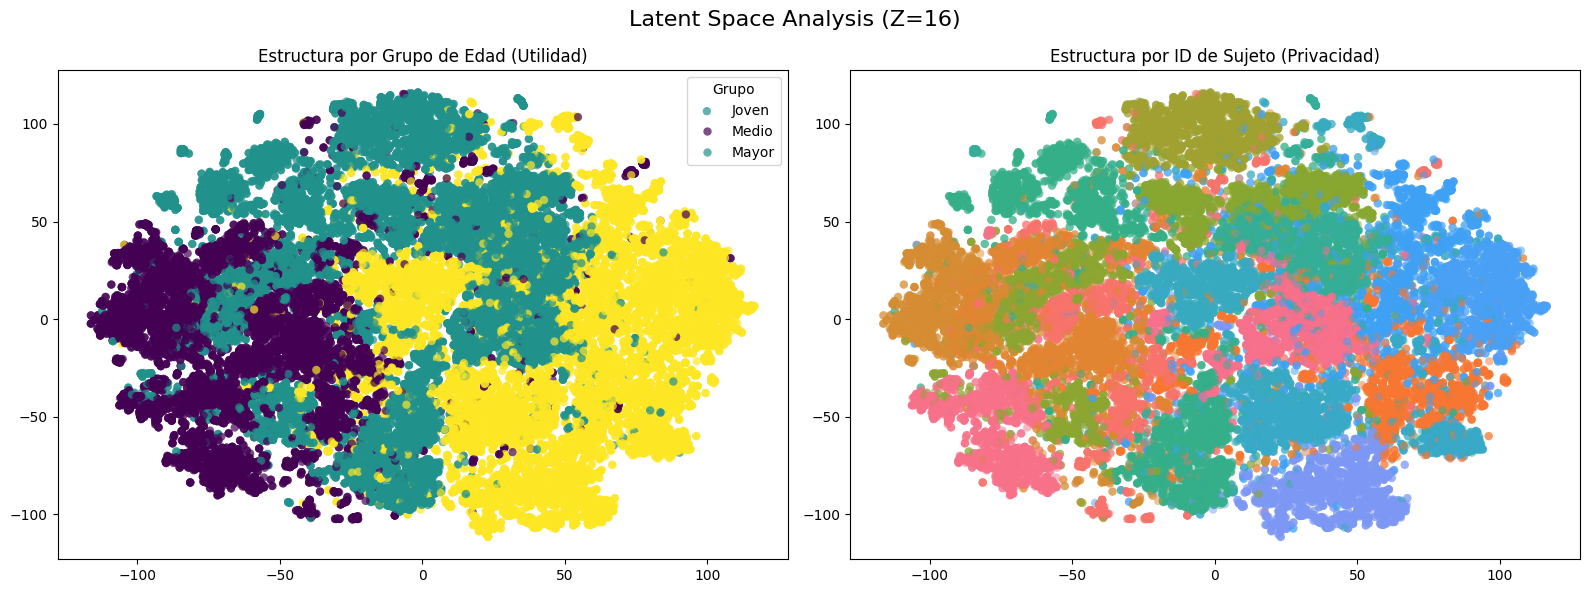

Número de puntos en el gráfico: 40800
Número de sujetos únicos: 17


In [21]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def plot_final_tsne(Z, y_group, subj_ids, title="Latent Space Analysis (Z=16)"):
    # 1. Calcular T-SNE
    print("Calculando T-SNE... (esto puede tardar un poco)")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    z_2d = tsne.fit_transform(Z)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Panel A: Utilidad (Edad)
    # Queremos ver grupos definidos o una gradiente clara
    sns.scatterplot(x=z_2d[:, 0], y=z_2d[:, 1], hue=y_group, 
                    palette="viridis", ax=ax1, alpha=0.7, edgecolor='none')
    ax1.set_title("Estructura por Grupo de Edad (Utilidad)")
    ax1.legend(title="Grupo", labels=['Joven', 'Medio', 'Mayor'])

    # Panel B: Privacidad (Sujeto)
    # Queremos ver una "sopa de colores" mezclada
    # Usamos una paleta con muchos colores para los 108 sujetos
    sns.scatterplot(x=z_2d[:, 0], y=z_2d[:, 1], hue=subj_ids, 
                    palette="husl", ax=ax2, alpha=0.5, edgecolor='none', legend=False)
    ax2.set_title("Estructura por ID de Sujeto (Privacidad)")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Ejecutar con tus datos de Test
plot_final_tsne(Zt, yt, subjt)

print(f"Número de puntos en el gráfico: {Zt.shape[0]}")
print(f"Número de sujetos únicos: {len(np.unique(subjt))}")

##  Clustering 

In [23]:
#  --- IGNORE --- To check the random seed and batch composition
xs = []
subs = []
grps = []

it = iter(test_loader)
for _ in range(3):  # 3 batches
    x_batch, meta, cycle_id = next(it)
    subs.append(meta[:,0].cpu().numpy())
    grps.append(meta[:,1].cpu().numpy())
    xs.append(x_batch.shape[0])

print("batch_sizes:", xs)
print("first 20 subj ids:", np.concatenate(subs)[:20])
print("first 20 group ids:", np.concatenate(grps)[:20])

batch_sizes: [136, 136, 136]
first 20 subj ids: [107.  21. 104.  82. 175.  50. 120. 119.  21.  75. 104. 119.  50.  42.
  50.   8. 175. 125.  75.  50.]
first 20 group ids: [3. 1. 3. 2. 2. 2. 3. 3. 1. 2. 3. 3. 2. 2. 2. 1. 2. 3. 2. 2.]


In [24]:
# --- IGNORE --- How pure are the batches in terms of subject composition?
purities = []
for i, (x, meta, *rest) in enumerate(test_loader):
    meta_np = meta[:,:].cpu().numpy()
    subj = meta_np[:,0].astype(int)
    # pureza del batch por sujeto
    vals, cnts = np.unique(subj, return_counts=True)
    purities.append(cnts.max()/cnts.sum())
    if i < 5:
        print("Batch", i, "purity:", purities[-1], "top subj:", vals[np.argmax(cnts)])

print("Mean batch subject-purity:", np.mean(purities))

Batch 0 purity: 0.058823529411764705 top subj: 2
Batch 1 purity: 0.058823529411764705 top subj: 2
Batch 2 purity: 0.058823529411764705 top subj: 2
Batch 3 purity: 0.058823529411764705 top subj: 2
Batch 4 purity: 0.058823529411764705 top subj: 2


KeyboardInterrupt: 

Unique GMM labels: [0 1 2]

=== GMM on SemiSupAE latent ===
Silhouette: 0.1554
ARI:        0.1731
NMI:        0.2427

=== External metrics (GMM) ===
Homogeneity:  0.2328
Completeness: 0.2534
V-measure:    0.2427

=== Cluster Purity (GMM) ===
Cluster 0: Purity = 0.7623, size = 6205
Cluster 1: Purity = 0.6975, size = 12868
Cluster 2: Purity = 0.5276, size = 21727

=== Internal structure metrics (GMM) ===
Calinski–Harabasz: 9647.5
Davies–Bouldin:    1.6916

Accuracy after cluster→group mapping: 0.617


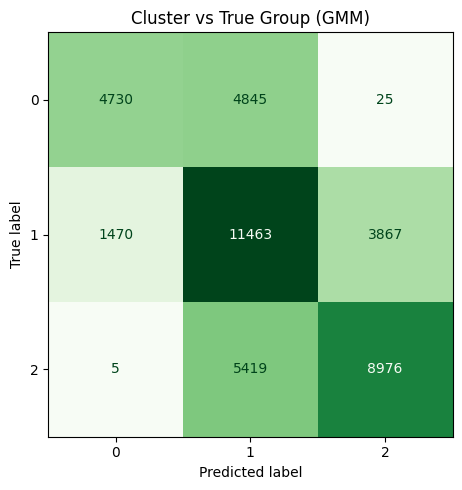

In [26]:
#Gaussian Mixture Model on SemiSupAE latents
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
      accuracy_score, classification_report,
      adjusted_rand_score, normalized_mutual_info_score,
    silhouette_score, davies_bouldin_score, homogeneity_score, completeness_score, v_measure_score,
    calinski_harabasz_score, f1_score, roc_auc_score
)
from collections import Counter


N_COMPONENTS = 3
RANDOM_STATE = 42

gmm = GaussianMixture(
    n_components=N_COMPONENTS,
    covariance_type="full",   #can try "diag" as well
    n_init=20,
    random_state=RANDOM_STATE
)
latents=Zt
gmm.fit(latents)
gmm_labels = gmm.predict(latents)
np.save("gmm_labels.npy", gmm_labels)
print("Unique GMM labels:", np.unique(gmm_labels))

# ── Basic external metrics ────────────────────────────────────────────────
sil_gmm = silhouette_score(latents, gmm_labels)
ari_gmm = adjusted_rand_score(yt, gmm_labels)
nmi_gmm = normalized_mutual_info_score(yt, gmm_labels)

print("\n=== GMM on SemiSupAE latent ===")
print(f"Silhouette: {sil_gmm:.4f}")
print(f"ARI:        {ari_gmm:.4f}")
print(f"NMI:        {nmi_gmm:.4f}")

# ── External evaluation: homogeneity / completeness / V-measure ──────────
h_gmm = homogeneity_score(yt, gmm_labels)
c_gmm = completeness_score(yt, gmm_labels)
v_gmm = v_measure_score(yt, gmm_labels)

print("\n=== External metrics (GMM) ===")
print(f"Homogeneity:  {h_gmm:.4f}")
print(f"Completeness: {c_gmm:.4f}")
print(f"V-measure:    {v_gmm:.4f}")

# ── Cluster purity ────────────────────────────────────────────────────────
print("\n=== Cluster Purity (GMM) ===")
for cu in np.unique(gmm_labels):
    idxs = np.where(gmm_labels == cu)[0]
    # groups must be integer-coded for bincount
    purity = np.max(np.bincount(yt[idxs])) / len(idxs)
    print(f"Cluster {cu}: Purity = {purity:.4f}, size = {len(idxs)}")

# ── Internal structure metrics ────────────────────────────────────────────
ch_gmm = calinski_harabasz_score(latents, gmm_labels)
db_gmm = davies_bouldin_score(latents, gmm_labels)

print("\n=== Internal structure metrics (GMM) ===")
print(f"Calinski–Harabasz: {ch_gmm:.1f}")
print(f"Davies–Bouldin:    {db_gmm:.4f}")

# ── Cluster → group mapping (majority vote) ──────────────────────────────
mapping_gmm = {}
for cu in np.unique(gmm_labels):
    idxs = np.where(gmm_labels == cu)[0]
    most_common = Counter(yt[idxs]).most_common(1)[0][0]
    mapping_gmm[cu] = most_common

aligned_gmm = np.vectorize(mapping_gmm.get)(gmm_labels)
acc_gmm = (aligned_gmm == yt).mean()
print(f"\nAccuracy after cluster→group mapping: {acc_gmm:.3f}")

# ── Confusion matrix ─────────────────────────────────────────────────────
cm_gmm = confusion_matrix(yt, aligned_gmm)

fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay(cm_gmm).plot(
    cmap="Greens",
    ax=ax,
    values_format="d",
    colorbar=False
)
ax.set_title("Cluster vs True Group (GMM)")
plt.tight_layout()
plt.show()

=== HDBSCAN Clustering (Noise Ratio: 79.57%) ===
Clusters encontrados (excluyendo ruido): 5
Alineación con GRUPO  (Utilidad): ARI=0.6530, NMI=0.7363
Alineación con SUJETO (Privacidad): ARI=0.6990, NMI=0.8184
Ratio Utilidad/Privacidad (ARI): 0.93

=== Detalle por Cluster (Pureza y Tamaño) ===
Cluster  0: Pureza=0.9983 | Tamaño= 599 | Grupo Dominante=1
Cluster  1: Pureza=0.8540 | Tamaño=2672 | Grupo Dominante=0
Cluster  2: Pureza=0.9990 | Tamaño=1035 | Grupo Dominante=2
Cluster  3: Pureza=1.0000 | Tamaño=1248 | Grupo Dominante=2
Cluster  4: Pureza=0.9996 | Tamaño=2780 | Grupo Dominante=1

=== Métricas de Estructura Interna (Solo puntos asignados) ===
Silhouette: 0.4481 | Calinski-Harabasz: 7718.0 | Davies-Bouldin: 0.9142

Exactitud tras mapeo Cluster -> Grupo: 0.9528


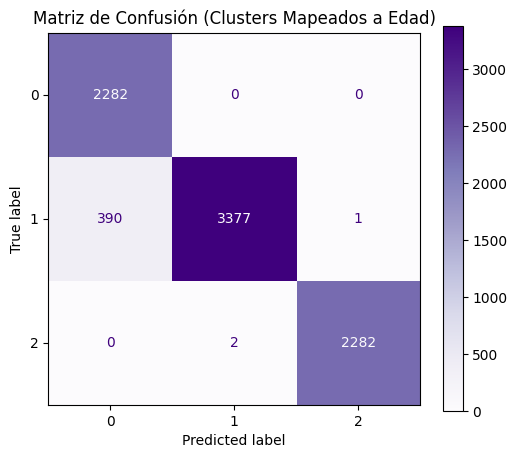

In [38]:
#HDBSCAN clustering on SemiSupAE latents ───────────────────────────────
import hdbscan 

scaler = StandardScaler()
latents_scaled = scaler.fit_transform(latents)

# --- 1. Ejecución de HDBSCAN ---
hdb = hdbscan.HDBSCAN(
    min_cluster_size=300, 
    min_samples=15,
    metric="euclidean"
)

hdb_labels = hdb.fit_predict(latents_scaled)
noise_mask = hdb_labels != -1

# --- 2. Extracción de subconjuntos válidos (sin ruido) ---
hdb_valid = hdb_labels[noise_mask]
latents_valid = latents_scaled[noise_mask]
groups_valid = yt[noise_mask]      # Edad
subjects_valid = subjt[noise_mask]  # Identidad (Sujeto)

# --- 3. Evaluación Dual: ¿Grupo o Sujeto? ---
def compute_alignment_metrics(true_labels, pred_labels, name="Group"):
    ari = adjusted_rand_score(true_labels, pred_labels)
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    return {f"ARI_{name}": ari, f"NMI_{name}": nmi}

met_group = compute_alignment_metrics(groups_valid, hdb_valid, "Group")
met_subj  = compute_alignment_metrics(subjects_valid, hdb_valid, "Subject")

print(f"=== HDBSCAN Clustering (Noise Ratio: {np.mean(~noise_mask)*100:.2f}%) ===")
print(f"Clusters encontrados (excluyendo ruido): {len(np.unique(hdb_valid))}")
print(f"Alineación con GRUPO  (Utilidad): ARI={met_group['ARI_Group']:.4f}, NMI={met_group['NMI_Group']:.4f}")
print(f"Alineación con SUJETO (Privacidad): ARI={met_subj['ARI_Subject']:.4f}, NMI={met_subj['NMI_Subject']:.4f}")

# Ratio de utilidad/privacidad: Un valor alto indica éxito del modelo adversarial
if met_subj['ARI_Subject'] > 0:
    print(f"Ratio Utilidad/Privacidad (ARI): {met_group['ARI_Group']/met_subj['ARI_Subject']:.2f}")

# --- 4. Pureza y Estructura por Cluster (Robusto con Counter) ---
print("\n=== Detalle por Cluster (Pureza y Tamaño) ===")
for cu in np.unique(hdb_valid):
    idxs = np.where(hdb_valid == cu)[0]
    counts = Counter(groups_valid[idxs])
    most_common_val, most_common_count = counts.most_common(1)[0]
    purity = most_common_count / len(idxs)
    print(f"Cluster {cu:2d}: Pureza={purity:.4f} | Tamaño={len(idxs):4d} | Grupo Dominante={most_common_val}")

# --- 5. Métricas Internas (Con salvaguarda estadística) ---
print("\n=== Métricas de Estructura Interna (Solo puntos asignados) ===")
n_unique_hdb = len(np.unique(hdb_valid))
if n_unique_hdb >= 2:
    sil = silhouette_score(latents_valid, hdb_valid)
    ch = calinski_harabasz_score(latents_valid, hdb_valid)
    db = davies_bouldin_score(latents_valid, hdb_valid)
    print(f"Silhouette: {sil:.4f} | Calinski-Harabasz: {ch:.1f} | Davies-Bouldin: {db:.4f}")
else:
    print("Métricas internas: N/A (Menos de 2 clusters encontrados)")

# --- 6. Mapping y Matriz de Confusión ---
mapping_hdb = {cu: Counter(groups_valid[np.where(hdb_valid == cu)[0]]).most_common(1)[0][0] 
               for cu in np.unique(hdb_valid)}

aligned_hdb = np.vectorize(mapping_hdb.get)(hdb_valid)
acc_mapping = (aligned_hdb == groups_valid).mean()

print(f"\nExactitud tras mapeo Cluster -> Grupo: {acc_mapping:.4f}")

# Visualización
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(groups_valid, aligned_hdb, cmap="Purples", ax=ax)
ax.set_title("Matriz de Confusión (Clusters Mapeados a Edad)")
plt.show()

Clusters per subject: count    15.000000
mean      1.266667
std       0.457738
min       1.000000
25%       1.000000
50%       1.000000
75%       1.500000
max       2.000000
Name: cluster, dtype: float64
Subjects per cluster: count    5.000000
mean     3.800000
std      1.643168
min      2.000000
25%      2.000000
50%      5.000000
75%      5.000000
max      5.000000
Name: subject, dtype: float64
Cluster sizes: count        6.000000
mean      6800.000000
std      12605.210589
min        599.000000
25%       1088.250000
50%       1960.000000
75%       2753.000000
max      32466.000000
Name: count, dtype: float64


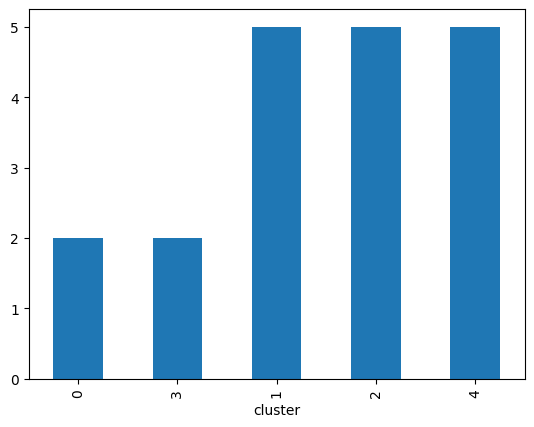

In [42]:
# Analyze number of clusters per subject
import pandas as pd
df = pd.DataFrame({
    "subject": subjt,
    "cluster": hdb_labels,
})

clusters_per_subject = (
    df[df.cluster >= 0]
    .groupby("subject")["cluster"]
    .nunique()
)

print("Clusters per subject:", clusters_per_subject.describe())

# Analyze number of subjects per cluster
subjects_per_cluster = (
    df[df.cluster >= 0]
    .groupby("cluster")["subject"]
    .nunique()
)

print("Subjects per cluster:", subjects_per_cluster.describe())

subjects_per_cluster.sort_values().plot(kind="bar")

cluster_sizes = pd.Series(hdb_labels).value_counts()
print("Cluster sizes:", cluster_sizes.describe())

In [40]:
def mean_dwell_time(labels):
    runs = []
    curr = labels[0]
    length = 1
    for l in labels[1:]:
        if l == curr:
            length += 1
        else:
            runs.append(length)
            curr = l
            length = 1
    runs.append(length)
    return np.mean(runs)

dwell = []
for subj in np.unique(subjt):
    seq = hdb_labels[subjt == subj]
    seq = seq[seq >= 0]
    if len(seq) > 0:
        dwell.append(mean_dwell_time(seq))

print("Mean dwell time:", np.mean(dwell))


Mean dwell time: 463.1944444444444


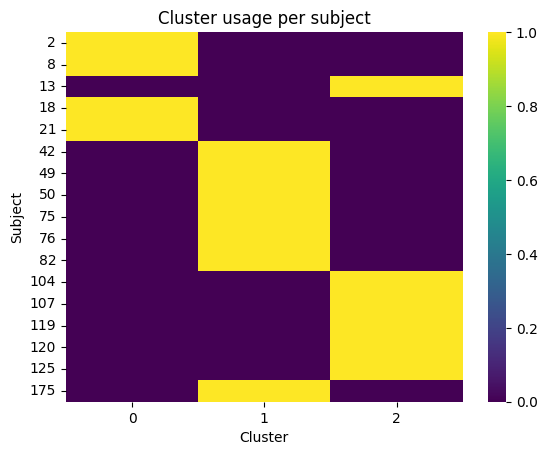

In [41]:
import seaborn as sns
pivot = (
    df[df.cluster >= 0]
    .pivot_table(index="subject", columns="cluster", aggfunc="size", fill_value=0)
)

pivot_norm = pivot.div(pivot.sum(axis=1), axis=0)

sns.heatmap(pivot_norm, cmap="viridis")
plt.title("Cluster usage per subject")
plt.xlabel("Cluster")
plt.ylabel("Subject")
plt.show()


In [44]:
# ¿Edad es linealmente separable en Z?
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

clf = LogisticRegression(max_iter=1000)
scores = cross_val_score(clf, Zt, yt, cv=5, scoring='balanced_accuracy')

print("Balanced Acc (5-fold CV):", scores.mean())


Balanced Acc (5-fold CV): 0.8213723544973544


In [49]:
print(f"Shapes -> Z_lda: {Z_lda.shape}, yt: {len(yt)}")

Shapes -> Z_lda: (40800, 2), yt: 40800


<Figure size 1000x600 with 0 Axes>

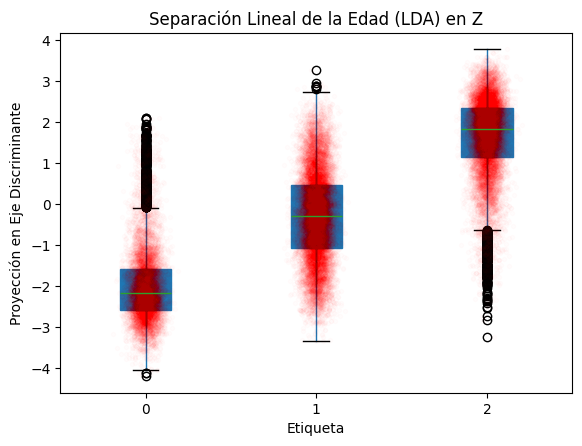

In [56]:
# LDA para encontrar el eje discriminante 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
Z_lda = lda.fit_transform(Zt, yt)


# 1. Aseguramos que tenemos los datos en el DataFrame
df_lda = pd.DataFrame({
    'Eje': Z_lda[:, 0],
    'Etiqueta': np.array(yt).flatten()
})

# 2. Usamos el boxplot nativo de Pandas (es el más difícil de romper)
plt.figure(figsize=(10, 6))
df_lda.boxplot(column='Eje', by='Etiqueta', grid=False, patch_artist=True)

# 3. Añadimos los puntos (opcional)
# Esto es para ver la densidad real de tus 40,800 registros
for i, (name, group) in enumerate(df_lda.groupby('Etiqueta')):
    y = group['Eje']
    # i+1 es la posición en el eje X
    x = np.random.normal(i + 1, 0.05, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.01) # alpha casi invisible por el gran volumen

plt.title('Separación Lineal de la Edad (LDA) en Z')
plt.suptitle('') # Elimina el título automático feo de Pandas
plt.ylabel('Proyección en Eje Discriminante')
plt.show()

Top 10 variables que definen el eje de envejecimiento:
       Feature      Peso  Abs_Peso
9    Feature_9  0.661477  0.661477
12  Feature_12 -0.610502  0.610502
10  Feature_10  0.521962  0.521962
15  Feature_15 -0.513901  0.513901
8    Feature_8 -0.353195  0.353195
13  Feature_13 -0.245623  0.245623
7    Feature_7 -0.244652  0.244652
6    Feature_6 -0.241834  0.241834
3    Feature_3  0.208926  0.208926
11  Feature_11  0.071838  0.071838


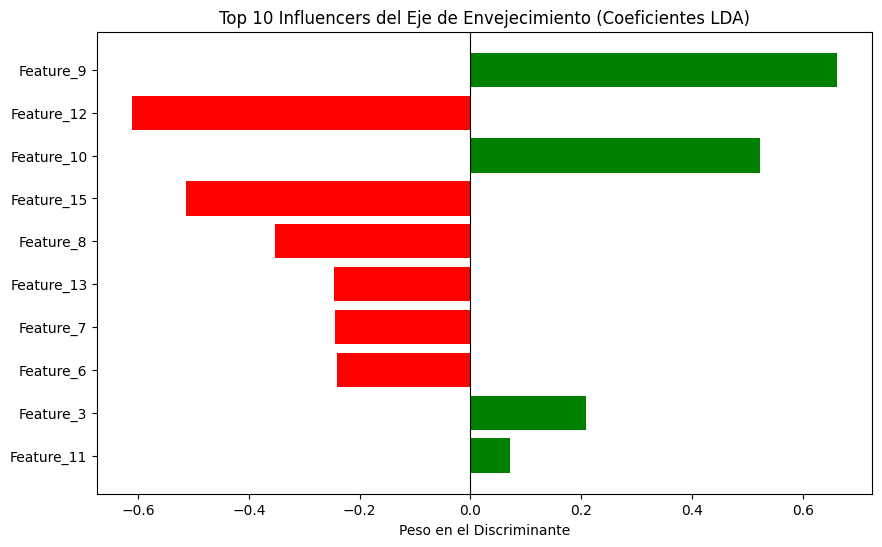

In [57]:
# Que variables impulsan esa separacion 
import pandas as pd
import matplotlib.pyplot as plt

# 1. Extraer los coeficientes del primer componente (el eje que graficamos)
# lda.scalings_ contiene los pesos de las variables originales
pesos = lda.scalings_[:, 0] 

# 2. Si Zt tiene nombres de columnas, los usamos; si no, creamos genéricos
nombres_features = Zt.columns if hasattr(Zt, 'columns') else [f'Feature_{i}' for i in range(Zt.shape[1])]

# 3. Crear un DataFrame para organizar los pesos
df_pesos = pd.DataFrame({
    'Feature': nombres_features,
    'Peso': pesos,
    'Abs_Peso': abs(pesos) # Para ordenar por importancia real (positiva o negativa)
}).sort_values(by='Abs_Peso', ascending=False)

# 4. Mostrar el Top 10
print("Top 10 variables que definen el eje de envejecimiento:")
print(df_pesos.head(10))

# 5. Visualizar las más importantes
plt.figure(figsize=(10, 6))
top_10 = df_pesos.head(10)
plt.barh(top_10['Feature'], top_10['Peso'], color=['red' if x < 0 else 'green' for x in top_10['Peso']])
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Top 10 Influencers del Eje de Envejecimiento (Coeficientes LDA)')
plt.xlabel('Peso en el Discriminante')
plt.gca().invert_yaxis() # Para que la más importante esté arriba
plt.show()